In [1]:
# change the display more comfortable
import seaborn as sbn
sbn.set()

from IPython.display import HTML
CSS="""#notebook-container {
    width: 100%
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .input {
    width: 50%
}

.code_cell .output_wrapper {
    width: 50%
}"""
HTML('<style>{}</style>'.format(CSS))

In [2]:
# -*- coding: utf-8 -*-
__author__ = 'huangyf'

import os
import re
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from torch import nn, optim
from data_loader import get_loader
from torchvision import transforms
from models import alex
from utils import AverageMeter, accuracy, get_margin, ramp_loss, margin_error, get_Lip

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

use_gpu = torch.cuda.is_available()


def train_model(model, criterion, optimizer, log_saver, g0, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'train1', 'test']:

            margin = []
            loss_meter = AverageMeter()
            rloss_meter = AverageMeter()
            ramp_loss_meter = AverageMeter()
            acc_meter = AverageMeter()
            margin_error_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[re.findall('[a-zA-Z]+',
                                                        phase)[0]]):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1

                N = outputs.size(0)

                margin = np.append(margin, get_margin(outputs, labels))
                loss_meter.update(loss.data.item(), N)
                acc_meter.update(
                    accuracy(outputs.data, labels.data)[-1].item(), N)

                if phase != 'train':
                    gamma = log_saver['Lip'][-1] * g0
                    ramp_loss_meter.update(
                        ramp_loss(get_margin(outputs, labels), gamma), N)
                    rloss_meter.update(
                        criterion(outputs / log_saver['Lip'][-1],
                                  labels).data.item(), N)
                    margin_error_meter.update(
                        margin_error(get_margin(outputs, labels), gamma), N)

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':
                model.eval()
                log_saver['Lip'].append(get_Lip(model,'alex'))

            if phase == 'train1':

                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)
                log_saver['margin_train'].append(margin)
                log_saver['train_rloss'].append(rloss_meter.avg)
                log_saver['train_ramp_loss'].append(ramp_loss_meter.avg)
                log_saver['train_margin_error'].append(margin_error_meter.avg)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)
                log_saver['margin_test'].append(margin)
                log_saver['test_rloss'].append(rloss_meter.avg)
                log_saver['test_ramp_loss'].append(ramp_loss_meter.avg)
                log_saver['test_margin_error'].append(margin_error_meter.avg)

            if phase != 'train':
                print(
                    f'{phase} Loss: {epoch_loss:.4f} rLoss: {rloss_meter.avg:.4f} Error: {epoch_error:.4f}',
                    f'RampLoss: {ramp_loss_meter.avg:.6f} MarginError: {margin_error_meter.avg:.4f}',
                    f"Margin: {min(margin):.4f} Lip: {log_saver['Lip'][-1]:.4e}"
                )

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {'net': model, 'epoch': epoch, 'log': log_saver}

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state,
                       './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s'
    )

    return model, log_saver

/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def plot(log, q, result_dir):
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        #plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    def get_qmargin(margins, q):
        q1 = int(len(margins[0]) * q)
        return [np.partition(margin, q1)[q1] for margin in margins]

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, r'Normalised Margin')
    fig7, ax7 = get_fig(7, r'Normalised qMargin(.8)')
    fig8, ax8 = get_fig(8, r'qMargin(.8)')
    fig9, ax9 = get_fig(9, r'Rademacher Complexity')
    fig10, ax10 = get_fig(10, r'train rloss and test rloss')
    fig11, ax11 = get_fig(11, r'train rloss and test error')
    fig12, ax12 = get_fig(12, r'rc and test error')
    fig13, ax13 = get_fig(13, r'rloss')
    fig14, ax14 = get_fig(14, r'ramp loss')
    fig15, ax15 = get_fig(15, r'margin error and test error')
    fig16, ax16 = get_fig(16, r'margin error')

    ax1.plot(log['train_loss'],'r', linewidth=3, label='training')
    ax1.plot(log['test_loss'],'b', linewidth=3, label='test')
    ax1.set_ylabel('loss',fontdict=fontdict)
    ax2.plot(log['train_error'],'r', linewidth=3, label='training')
    ax2.plot(log['test_error'],'b', linewidth=3, label='test')
    ax2.set_ylabel('error',fontdict=fontdict)
    ax4.plot(
        [min(x) for x in log['margin_train']],'r', linewidth=3, label='training')
    ax4.plot([min(x) for x in log['margin_test']],'b', linewidth=3, label='test')

    ax14.plot(log['train_ramp_loss'],'r', linewidth=3, label='training')
    ax14.plot(log['test_ramp_loss'],'b', linewidth=3, label='test')

    ax8.plot(
        get_qmargin(log['margin_train'], q),'r', linewidth=3, label='training')
    ax8.plot(get_qmargin(log['margin_test'], q),'b', linewidth=3, label='test')
    ax13.plot(log['train_rloss'],'r', linewidth=3, label='training')
    ax13.plot(log['test_rloss'],'b', linewidth=3, label='test')

    ax16.plot(log['train_margin_error'],'r', linewidth=3, label='training')
    ax16.plot(log['test_margin_error'],'b', linewidth=3, label='test')

    log['nMargin_train'] = np.array([min(x) for x in log['margin_train']
                                     ]) / np.array(log['Lip'])
    log['nMargin_test'] = np.array([min(x) for x in log['margin_test']
                                    ]) / np.array(log['Lip'])

    ax5.plot(log['nMargin_train'],'r', linewidth=3, label='training')
    ax5.plot(log['nMargin_test'],'b', linewidth=3, label='test')

    log['nqMargin_train'] = np.array(get_qmargin(log['margin_train'],
                                                 q)) / np.array(log['Lip'])
    log['nqMargin_test'] = np.array(get_qmargin(log['margin_test'],
                                                q)) / np.array(log['Lip'])

    ax7.plot(1/log['nqMargin_train']*1e5,'r', linewidth=3, label=r'$1/\hat{\rho}_{q^{\ast}}$')
    ax7.plot(log['test_error'],'b', linewidth=3, label='test error')
    ax7.set_ylim(0,1)
    x1=np.argmin(1/log['nqMargin_train'])
    x2=np.argmin(log['test_error'])
    ax7.plot([x1,x1],[0,1/log['nqMargin_train'][x1]*1e5],'r--')
    ax7.plot([x2,x2],[0,log['test_error'][x2]],'b--')
    ax7.set_xticks([0,min(x1,x2),max(x1,x2),20,40,60,80])

    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.3)),
        linewidth=3,
        label='q=0.3')
    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.5)),
        linewidth=3,
        label='q=0.5')
    ax9.plot(
        np.array(log['Lip']) / np.array(get_qmargin(log['margin_train'], 0.8)),
        linewidth=3,
        label='q=0.8')

    ax10.scatter(
        log['train_rloss'],
        log['test_rloss'],
        label=
        f"corrcoef= {np.corrcoef(log['train_rloss'], log['test_rloss'])[0,1]:.4f}"
    )

    ax11.scatter(
        log['train_rloss'],
        log['test_error'],
        label=
        f"corrcoef= {np.corrcoef(log['train_rloss'], log['test_error'])[0,1]:.4f}"
    )

    log['RC'] = np.array(log['Lip']) / np.array(
        get_qmargin(log['margin_train'], q))
    ax12.scatter(
        log['RC'][10:],
        log['test_error'][10:],
        label=
        f"corrcoef= {np.corrcoef(log['RC'][10:], log['test_error'][10:])[0,1]:.4f}"
    )

    ax15.scatter(
        log['train_margin_error'],
        log['test_error'],
        label=
        f"corrcoef= {np.corrcoef(log['train_margin_error'], log['test_error'])[0,1]:.4f}"
    )

    for ax in [ax1, ax2, ax4, ax5, ax7, ax8, ax9, ax13, ax14, ax16]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    ax10.set_xlabel('train rloss', fontdict=fontdict)
    ax10.set_ylabel('test rloss', fontdict=fontdict)
    ax10.legend(loc='upper right', fontsize=20)

    ax11.set_xlabel('train rloss', fontdict=fontdict)
    ax11.set_ylabel('test error', fontdict=fontdict)
    ax11.legend(loc='upper right', fontsize=20)

    ax12.set_xlabel('train RC', fontdict=fontdict)
    ax12.set_ylabel('test error', fontdict=fontdict)
    ax12.legend(loc='upper right', fontsize=20)

    ax15.set_xlabel('train margin error', fontdict=fontdict)
    ax15.set_ylabel('test error', fontdict=fontdict)
    ax15.legend(loc='upper right', fontsize=20)

    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss.png')
    fig2.savefig(result_dir + 'error.png')
    fig4.savefig(result_dir + 'margin.png')
    fig5.savefig(result_dir + 'n_margin.png')
    fig7.savefig(result_dir + 'nq_margin.png')
    fig8.savefig(result_dir + 'q_margin.png')
    fig9.savefig(result_dir + 'rc.png')
    fig10.savefig(result_dir + 'rloss_rloss.png')
    fig11.savefig(result_dir + 'rloss_error.png')
    fig12.savefig(result_dir + 'rc_error.png')
    fig13.savefig(result_dir + 'rloss.png')
    fig14.savefig(result_dir + 'ramp_loss.png')
    fig15.savefig(result_dir + 'margin_error_test_error.png')
    fig16.savefig(result_dir + 'margin_error.png')

## Experiment on CIFAR10 with noise=0 for Alex
The codes are similar to margin_resnet18.ipynb and margin_vgg16.ipynb

In [4]:
#
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'original'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
model = alex.alexnet()

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: original ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 2472266


In [5]:
model, log = train_model(
    model, criterion, optimizer, log, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 2.2916 rLoss: 24077.6750 Error: 0.8456 RampLoss: 0.845593 MarginError: 0.8456 Margin: -0.2379 Lip: 1.5744e-06
test Loss: 2.2911 rLoss: 23969.3442 Error: 0.8397 RampLoss: 0.839700 MarginError: 0.8397 Margin: -0.2319 Lip: 1.5744e-06
Saving..
Epoch 2/100
----------
train1 Loss: 2.1820 rLoss: 145033.5092 Error: 0.8055 RampLoss: 0.805500 MarginError: 0.8055 Margin: -3.5372 Lip: 1.6577e-06
test Loss: 2.1852 rLoss: 147635.7922 Error: 0.8086 RampLoss: 0.808600 MarginError: 0.8086 Margin: -3.1674 Lip: 1.6577e-06
Epoch 3/100
----------
train1 Loss: 1.9438 rLoss: 250857.3040 Error: 0.7388 RampLoss: 0.738780 MarginError: 0.7388 Margin: -7.4905 Lip: 1.8489e-06
test Loss: 1.9577 rLoss: 257742.6608 Error: 0.7421 RampLoss: 0.742100 MarginError: 0.7421 Margin: -7.5728 Lip: 1.8489e-06
Epoch 4/100
----------
train1 Loss: 1.8356 rLoss: 242587.4255 Error: 0.6921 RampLoss: 0.692080 MarginError: 0.6921 Margin: -7.3575 Lip: 1.9756e-06
test Loss: 1.8523 rLoss: 249007.7455 Er

test Loss: 1.1569 rLoss: 118427.3195 Error: 0.3733 RampLoss: 0.373300 MarginError: 0.3733 Margin: -11.9505 Lip: 6.9201e-06
Saving..
Epoch 32/100
----------
train1 Loss: 0.5594 rLoss: 38169.1240 Error: 0.2014 RampLoss: 0.201400 MarginError: 0.2014 Margin: -10.0953 Lip: 7.2068e-06
test Loss: 1.2543 rLoss: 128634.7360 Error: 0.3883 RampLoss: 0.388300 MarginError: 0.3883 Margin: -13.3864 Lip: 7.2068e-06
Epoch 33/100
----------
train1 Loss: 0.4036 rLoss: 20213.6036 Error: 0.1335 RampLoss: 0.133540 MarginError: 0.1335 Margin: -11.7781 Lip: 7.5070e-06
test Loss: 1.1207 rLoss: 106926.0695 Error: 0.3512 RampLoss: 0.351200 MarginError: 0.3512 Margin: -12.9921 Lip: 7.5070e-06
Epoch 34/100
----------
train1 Loss: 0.4828 rLoss: 27773.9157 Error: 0.1772 RampLoss: 0.177240 MarginError: 0.1772 Margin: -9.8911 Lip: 7.8139e-06
test Loss: 1.2816 rLoss: 123442.4905 Error: 0.3809 RampLoss: 0.380900 MarginError: 0.3809 Margin: -14.5966 Lip: 7.8139e-06
Epoch 35/100
----------
train1 Loss: 0.4491 rLoss: 23772

Epoch 62/100
----------
train1 Loss: 0.0047 rLoss: 4.2355 Error: 0.0000 RampLoss: 0.000020 MarginError: 0.0000 Margin: -3.0779 Lip: 1.4534e-05
test Loss: 2.4715 rLoss: 162776.7862 Error: 0.3543 RampLoss: 0.354300 MarginError: 0.3543 Margin: -43.5987 Lip: 1.4534e-05
Epoch 63/100
----------
train1 Loss: 0.0034 rLoss: 1.5493 Error: 0.0000 RampLoss: 0.000040 MarginError: 0.0000 Margin: -0.8580 Lip: 1.4623e-05
test Loss: 2.5758 rLoss: 169379.9540 Error: 0.3535 RampLoss: 0.353500 MarginError: 0.3535 Margin: -46.0662 Lip: 1.4623e-05
Epoch 64/100
----------
train1 Loss: 0.0026 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 0.4063 Lip: 1.4696e-05
test Loss: 2.6443 rLoss: 173386.7734 Error: 0.3541 RampLoss: 0.354100 MarginError: 0.3541 Margin: -46.5210 Lip: 1.4696e-05
Epoch 65/100
----------
train1 Loss: 0.0022 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 0.2454 Lip: 1.4759e-05
test Loss: 2.7088 rLoss: 177201.3606 Error: 0.3542 RampLoss: 

train1 Loss: 0.0004 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 3.3063 Lip: 1.5553e-05
test Loss: 3.3073 rLoss: 207699.8434 Error: 0.3564 RampLoss: 0.356400 MarginError: 0.3564 Margin: -58.1761 Lip: 1.5553e-05
Epoch 94/100
----------
train1 Loss: 0.0004 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 3.1886 Lip: 1.5569e-05
test Loss: 3.3147 rLoss: 207977.9157 Error: 0.3566 RampLoss: 0.356600 MarginError: 0.3566 Margin: -58.2638 Lip: 1.5569e-05
Epoch 95/100
----------
train1 Loss: 0.0004 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 3.3000 Lip: 1.5585e-05
test Loss: 3.3264 rLoss: 208544.9437 Error: 0.3561 RampLoss: 0.356100 MarginError: 0.3561 Margin: -58.4222 Lip: 1.5585e-05
Epoch 96/100
----------
train1 Loss: 0.0004 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 3.2707 Lip: 1.5600e-05
test Loss: 3.3362 rLoss: 208970.4920 Error: 0.3570 RampLoss: 0.357000 MarginError: 0.35

In [6]:
import pickle
pickle.dump(log,open('./alex_results_original/log_original.log','wb'))

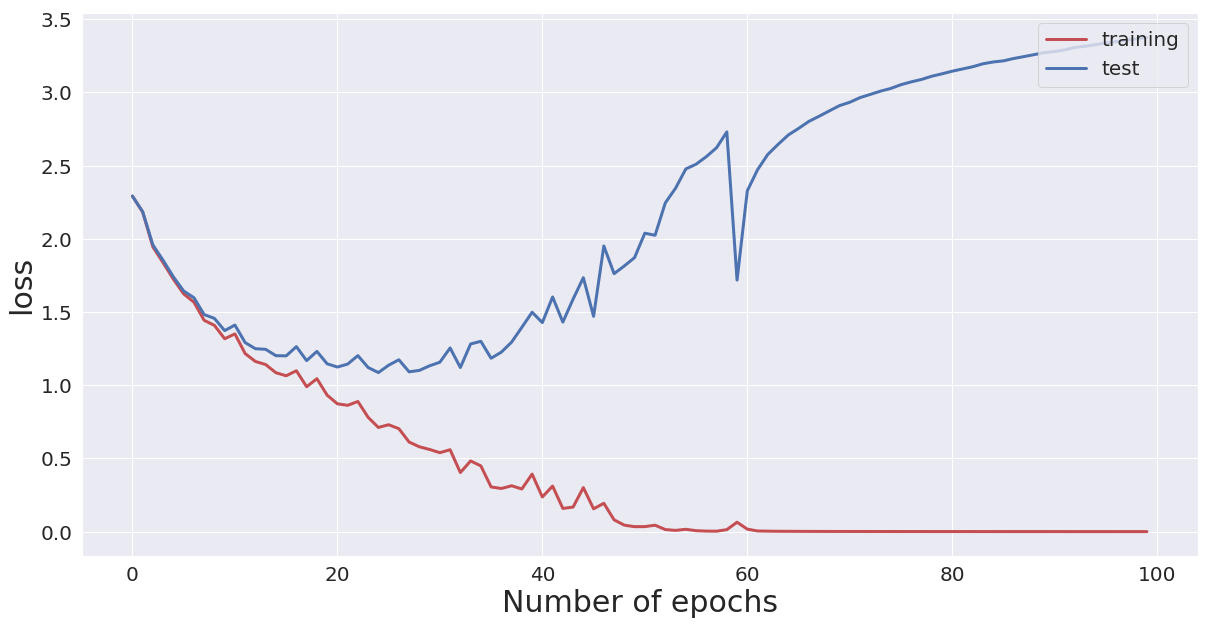

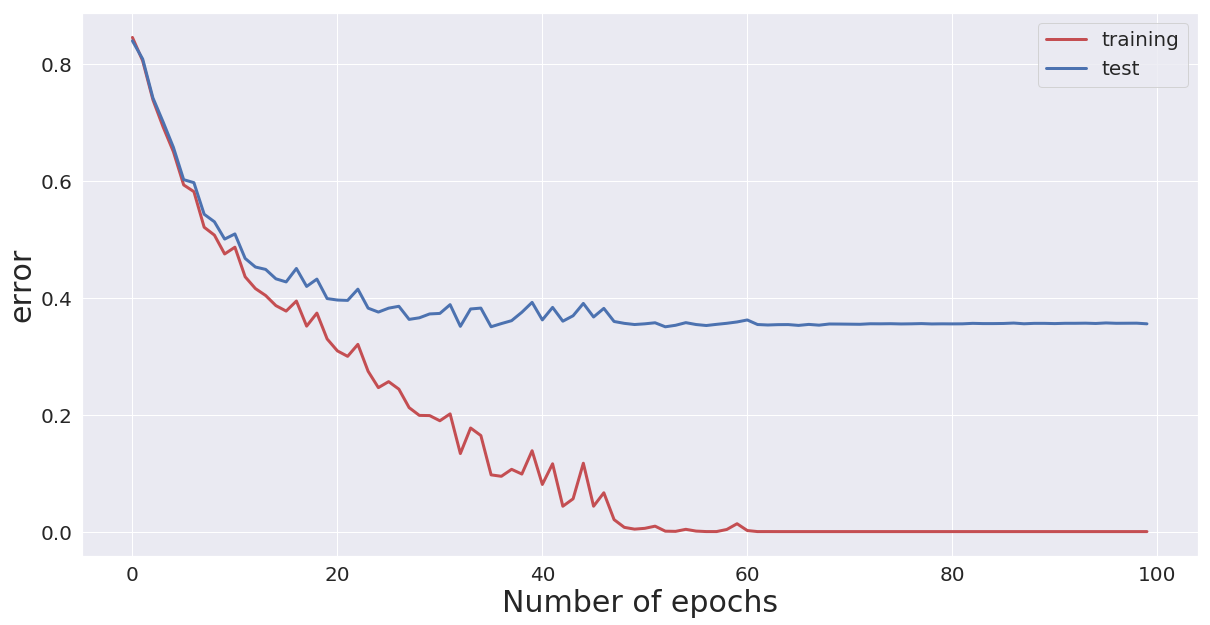

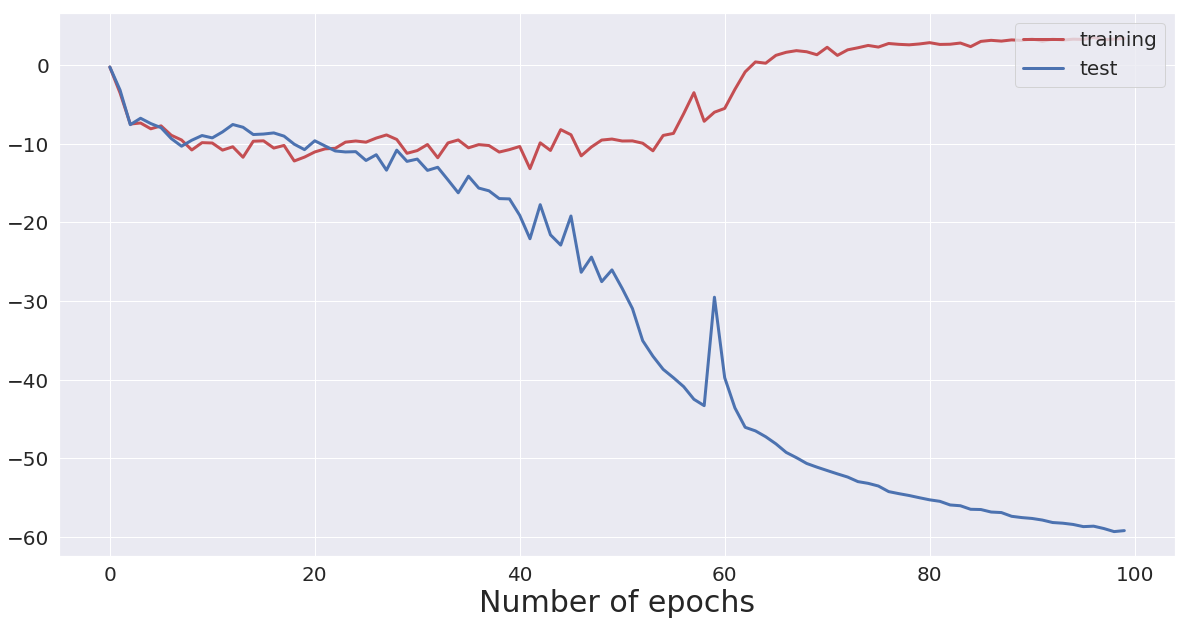

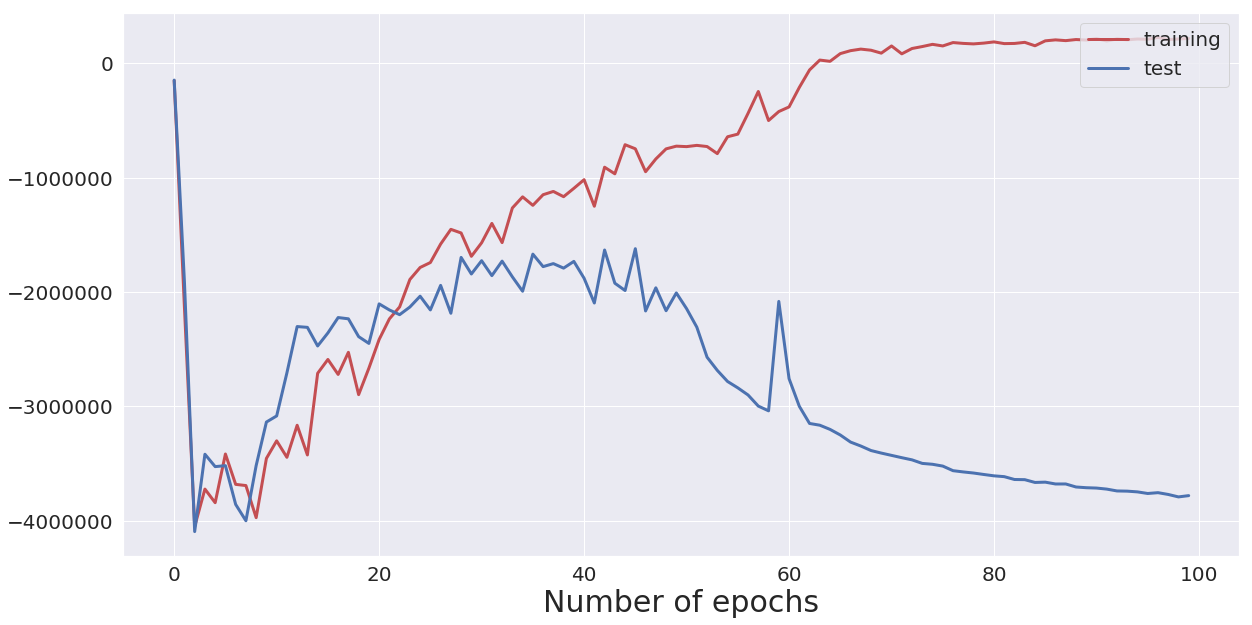

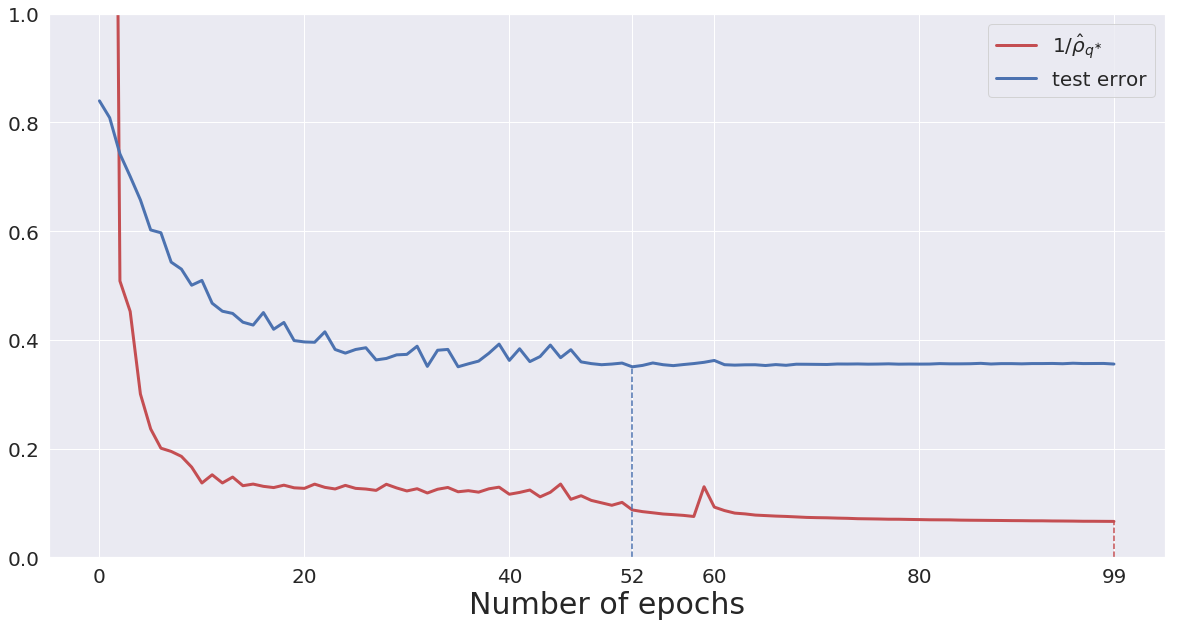

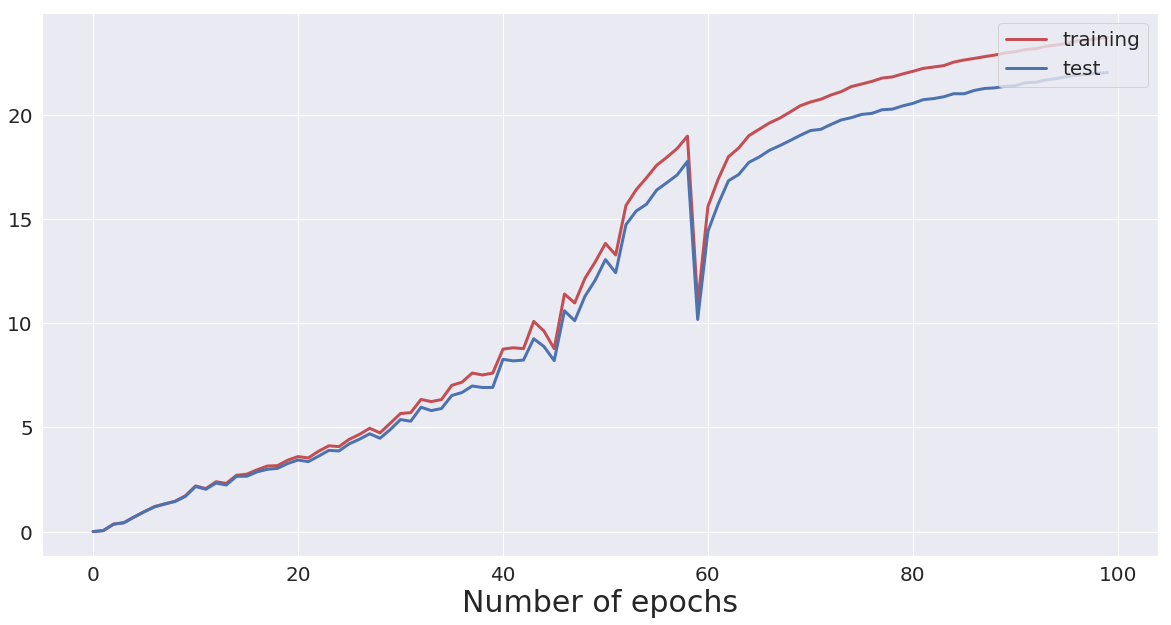

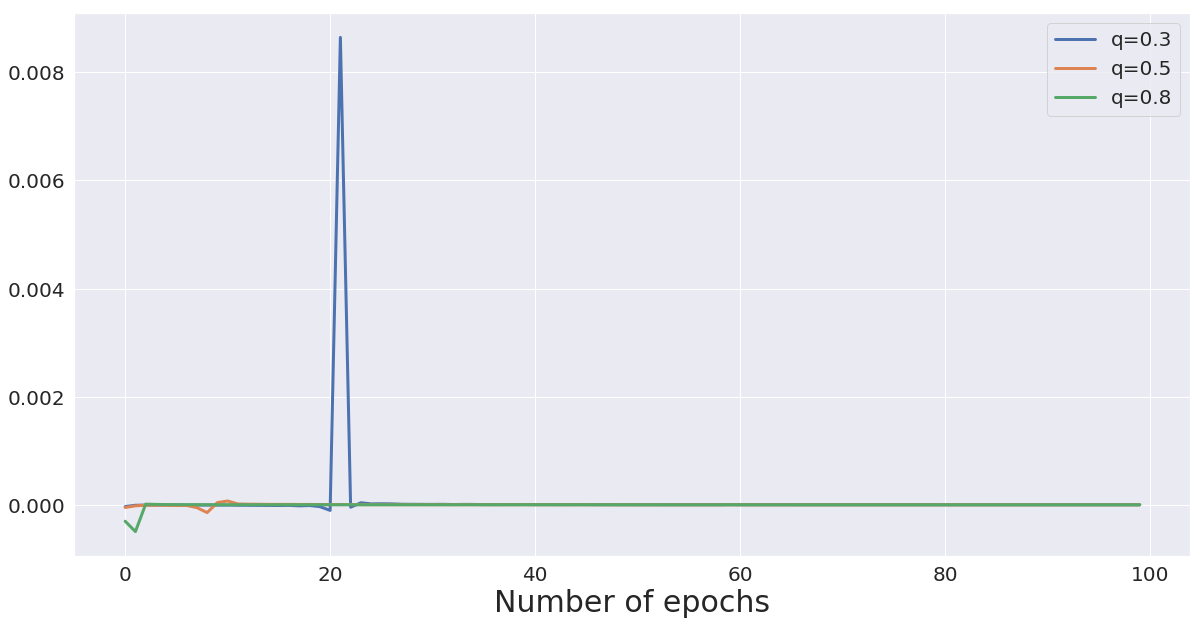

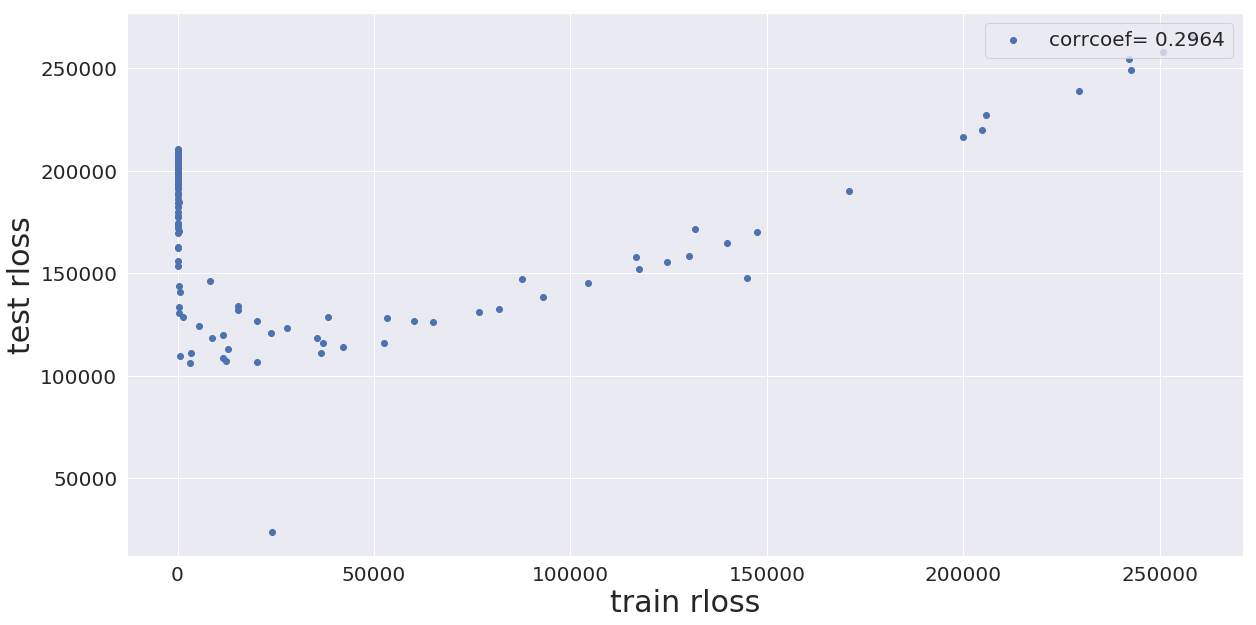

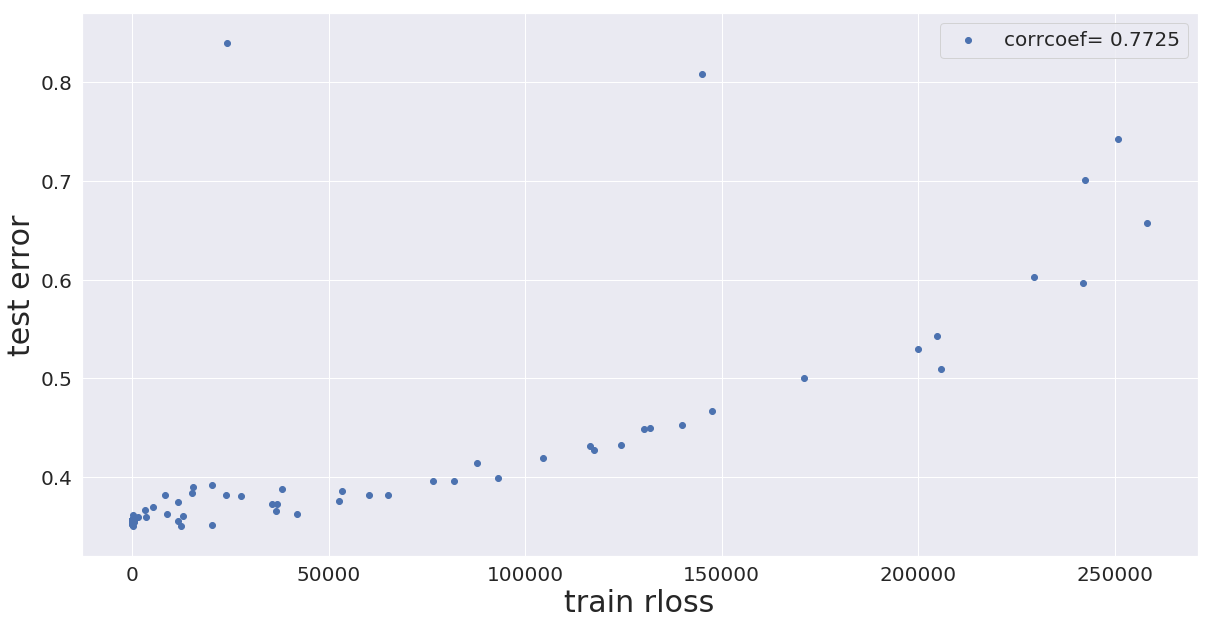

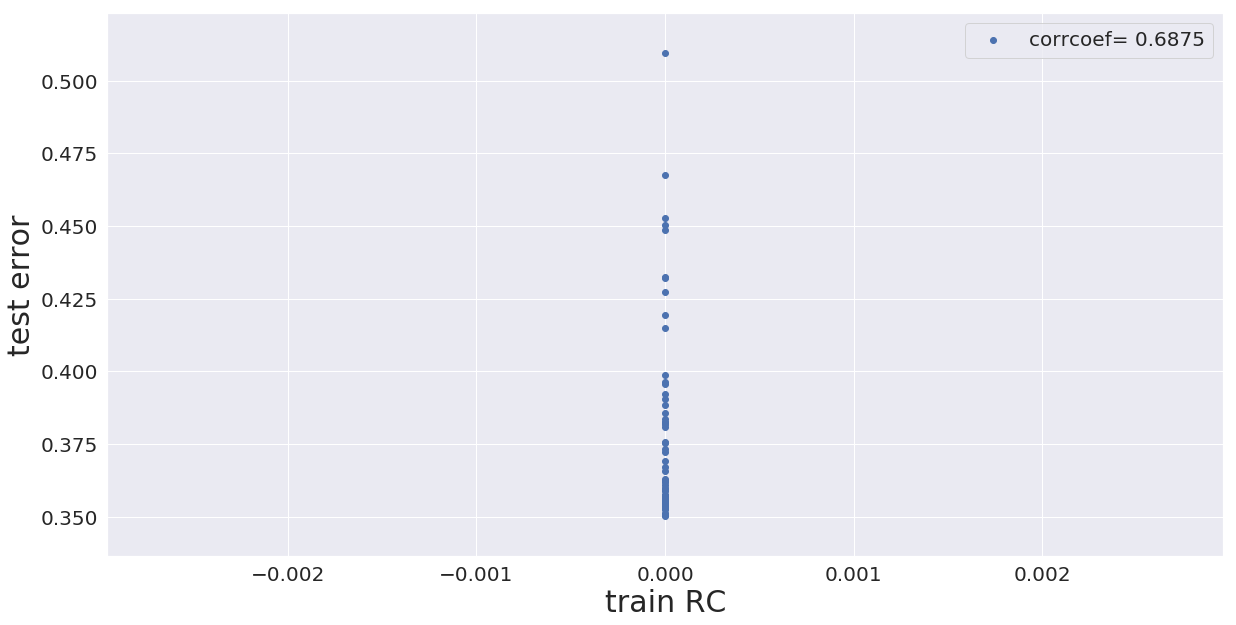

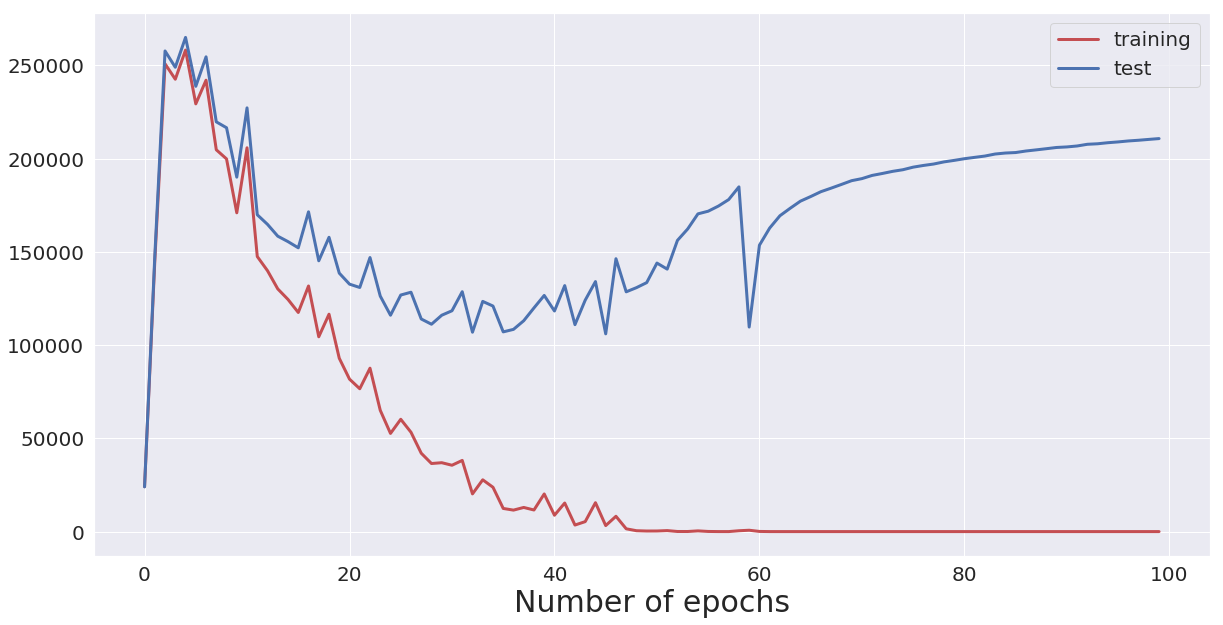

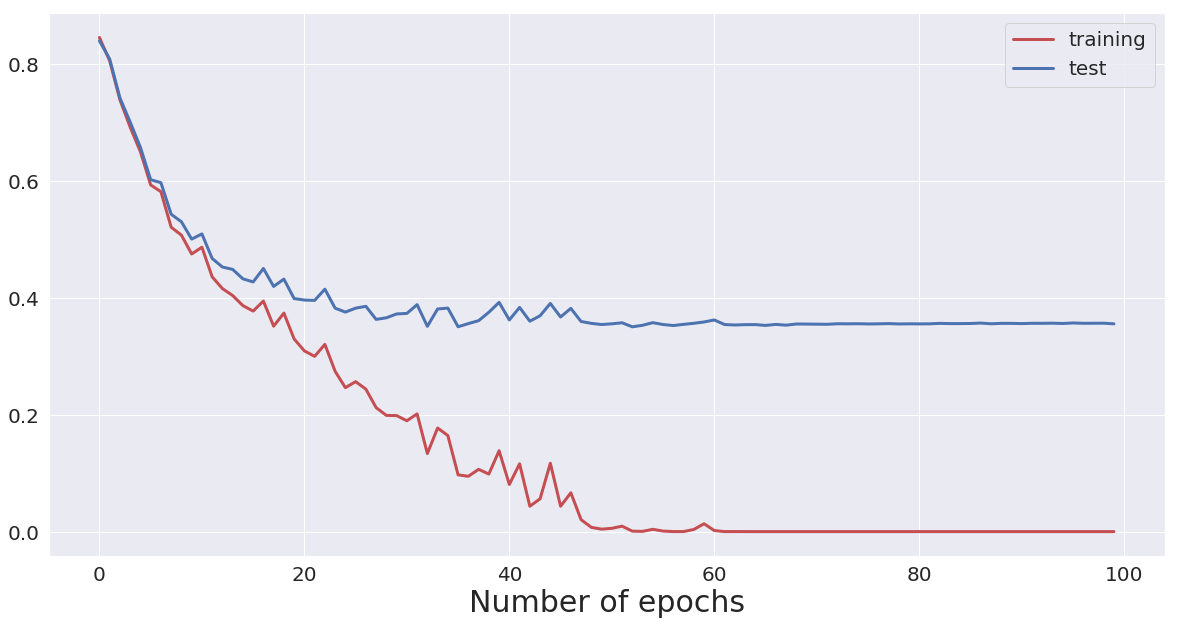

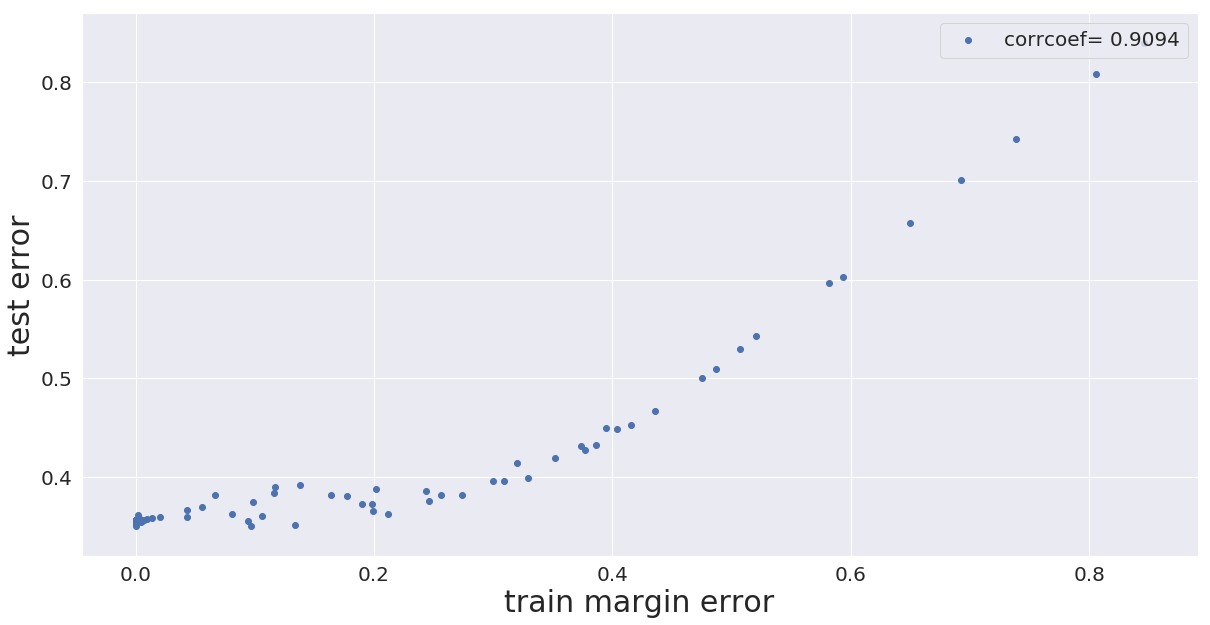

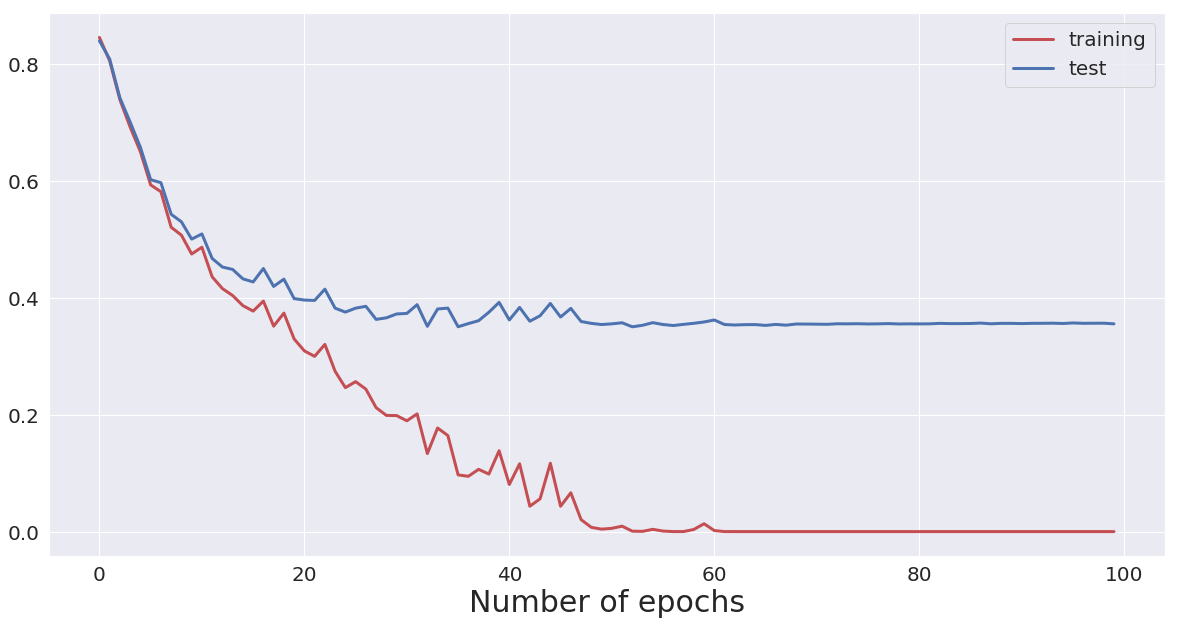

In [30]:
plot(log, 0.9, './alex_results_original/')
plt.show()

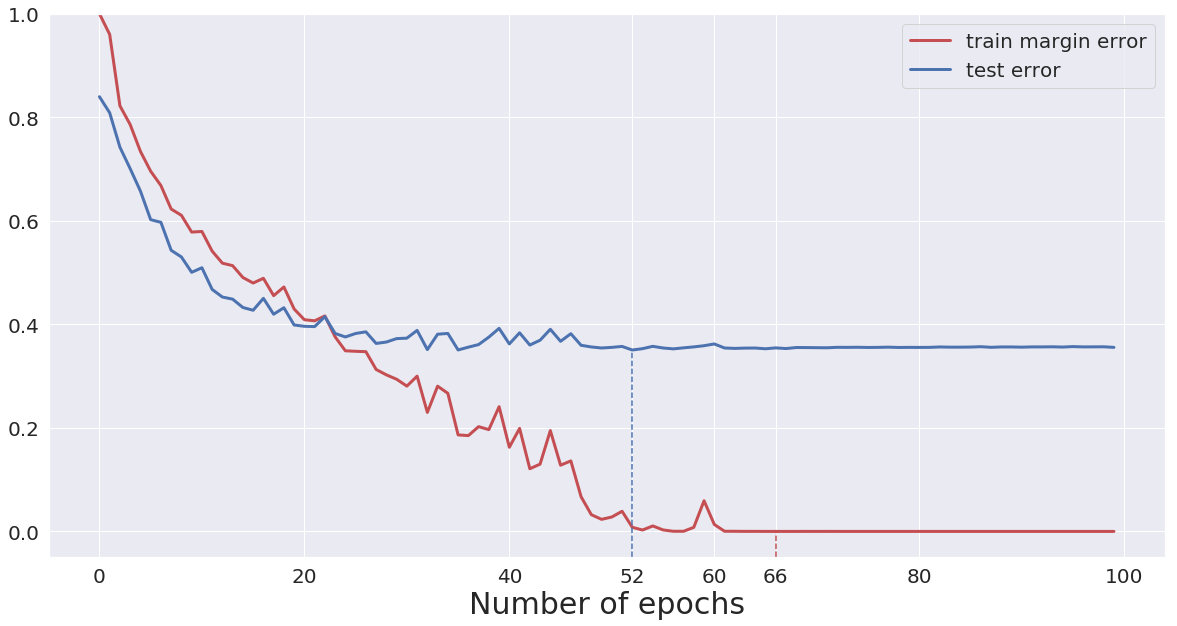

In [41]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 1e5) for (margin, lip) in zip(log['margin_train'], log['Lip'])]
ax.plot(train_merror
    ,'r',linewidth=3,
    label='train margin error')
ax.plot(log['test_error'],'b',linewidth=3,label='test error')
ax.legend(fontsize=20,loc='best')
#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1)
x1=np.argmin(log['test_error'])
ax.plot([x1,x1],[-0.05,log['test_error'][x1]],'b--')
x2=np.argmin(train_merror)
ax.plot([x2,x2],[-0.05,train_merror[x2]],'r--')
ax.set_xticks([0,min(x1,x2),max(x1,x2),20,40,60,80,100])
ax.set_xlabel('Number of epochs',fontdict={'size': 30})
fig.savefig('./alex_results_original/margin_error_and_test_error.png')

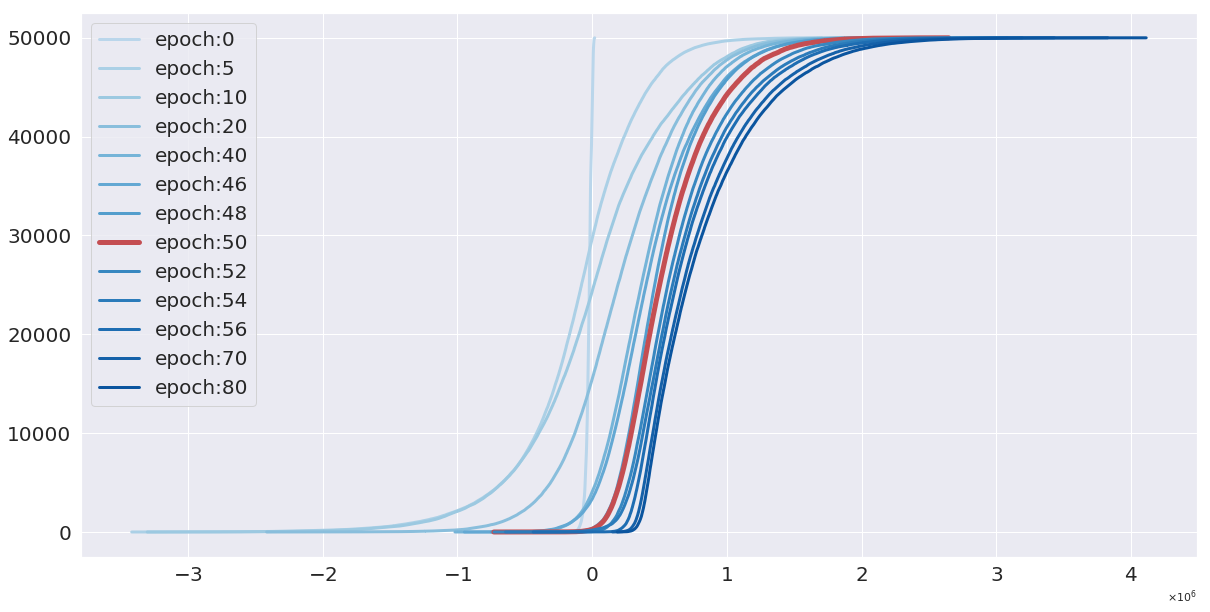

In [34]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,20, 40,46,48,50,52,54,56,70, 80]):
    if i==50:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log['margin_train'][i])/log['Lip'][i], range(50000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./alex_results_original/'+'nMargin_distribution.png')

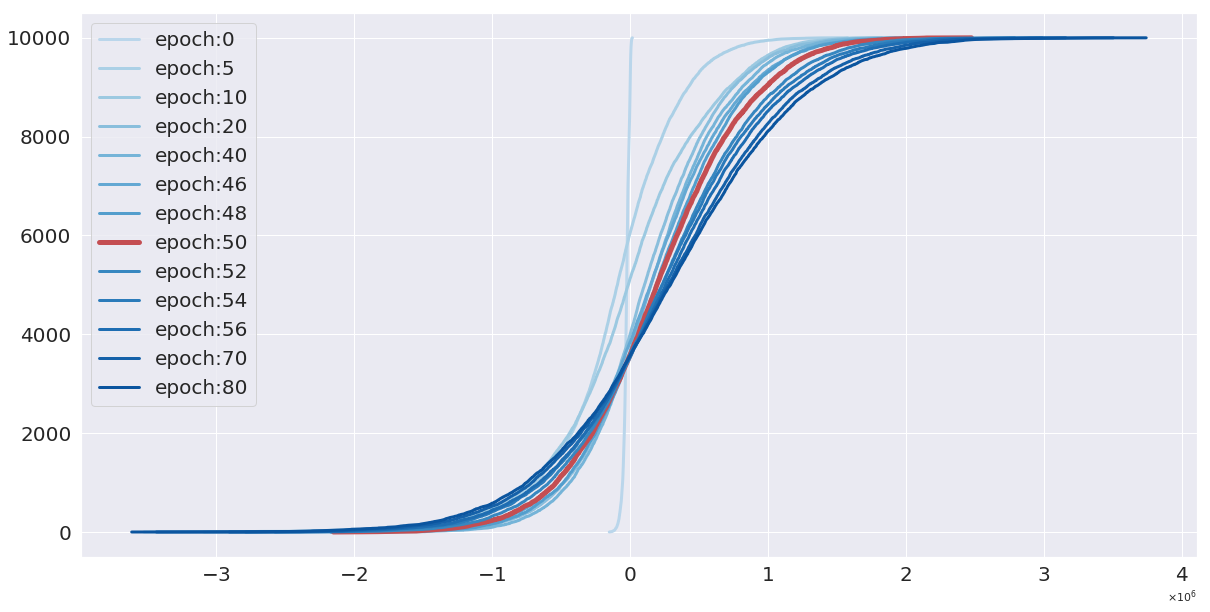

In [35]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,20, 40,46,48,50,52,54,56,70, 80]):
    if i==50:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log['margin_test'][i])/log['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./alex_results_original/'+'test_nMargin_distribution.png')

In [24]:
def plot_heatmap(log,path,interval):
    n=len(interval)
    corr=np.zeros((n,n))
    corr_linear=np.zeros((n,n))
    for i in range(n):
        g1=interval[i]
        train_merror=[margin_error(margin, lip * g1) for (margin, lip) in zip(log['margin_train'], log['Lip'])]
        for j in range(n):
            g2=interval[j]
            test_merror=[margin_error(margin, lip * g2) for (margin, lip) in zip(log['margin_test'], log['Lip'])]
            corr[i,j]=scipy.stats.spearmanr(train_merror,test_merror)[0]
            corr_linear[i,j]=np.corrcoef(train_merror,test_merror)[0,1]
    fig = plt.figure(1, figsize=(20, 10))
    ax = fig.add_subplot(111)
    im=ax.pcolormesh(interval,interval,corr,vmin=-0.8,vmax=0.8)
    fig.colorbar(im)
    ax.axis('tight')
    ax.set_xlabel('$\gamma_{1}$',fontsize=20)
    ax.set_ylabel('$\gamma_{2}$',fontsize=20)
    from matplotlib import ticker
    formatter=ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    fig.savefig(path+'margin_error_rankcorr.png')
    plt.show()
    
    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)
    im=ax.pcolormesh(interval,interval,corr_linear)
    fig.colorbar(im)
    ax.axis('tight')
    from matplotlib import ticker
    formatter=ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    fig.savefig(path+'margin_error_linearcorr.png')
    plt.show()

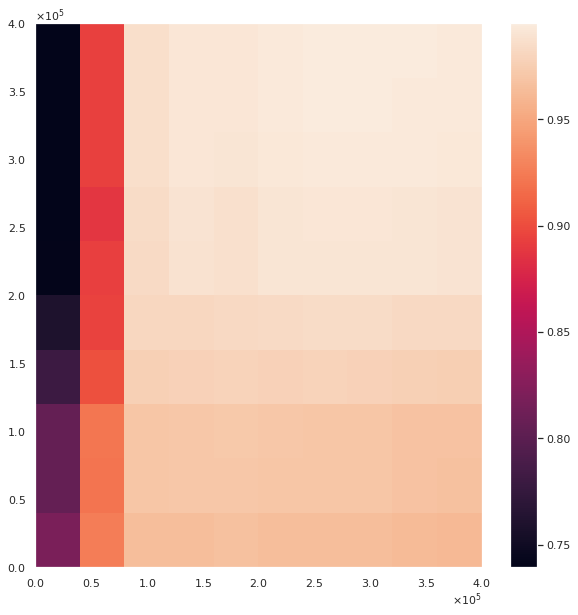

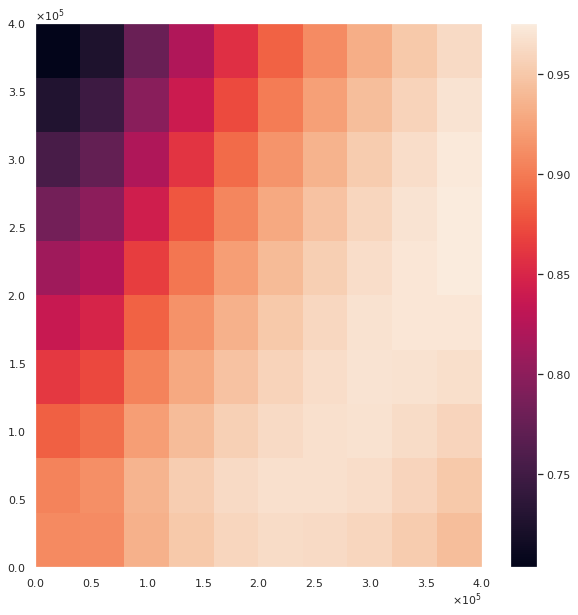

In [38]:
plot_heatmap(log,'./alex_results_original/',np.linspace(0,4e5,11))

## Experiment on CIFAR10 with noise=0.1 for Alex

In [14]:
#
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms)

loaders = {'train': training_loader, 'test': testing_loader}

log_1 = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
model = alex.alexnet()

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_1['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 2472266


In [15]:
model, log_1 = train_model(
    model, criterion, optimizer, log_1, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 2.2985 rLoss: 23463.6315 Error: 0.8786 RampLoss: 0.878620 MarginError: 0.8786 Margin: -0.1329 Lip: 1.5720e-06
test Loss: 2.2992 rLoss: 23914.2917 Error: 0.8792 RampLoss: 0.879200 MarginError: 0.8792 Margin: -0.1189 Lip: 1.5720e-06
Saving..
Epoch 2/100
----------
train1 Loss: 2.2784 rLoss: 40994.3241 Error: 0.8431 RampLoss: 0.843080 MarginError: 0.8431 Margin: -0.4162 Lip: 1.6024e-06
test Loss: 2.2801 rLoss: 42000.2703 Error: 0.8470 RampLoss: 0.847020 MarginError: 0.8471 Margin: -0.4155 Lip: 1.6024e-06
Epoch 3/100
----------
train1 Loss: 2.0969 rLoss: 197520.4367 Error: 0.7732 RampLoss: 0.773180 MarginError: 0.7732 Margin: -4.8388 Lip: 1.7472e-06
test Loss: 2.1076 rLoss: 201998.3508 Error: 0.7725 RampLoss: 0.772500 MarginError: 0.7725 Margin: -4.3453 Lip: 1.7472e-06
Epoch 4/100
----------
train1 Loss: 1.9828 rLoss: 251463.9557 Error: 0.7314 RampLoss: 0.731380 MarginError: 0.7314 Margin: -6.0303 Lip: 1.8662e-06
test Loss: 1.9968 rLoss: 256562.1570 Erro

test Loss: 1.3847 rLoss: 150628.5562 Error: 0.4260 RampLoss: 0.426000 MarginError: 0.4260 Margin: -10.1240 Lip: 5.5695e-06
Saving..
Epoch 32/100
----------
train1 Loss: 0.9571 rLoss: 80489.3357 Error: 0.2882 RampLoss: 0.288180 MarginError: 0.2882 Margin: -9.7940 Lip: 5.7864e-06
test Loss: 1.4168 rLoss: 151977.3290 Error: 0.4361 RampLoss: 0.436100 MarginError: 0.4361 Margin: -10.1307 Lip: 5.7864e-06
Epoch 33/100
----------
train1 Loss: 0.9488 rLoss: 76670.6736 Error: 0.2819 RampLoss: 0.281860 MarginError: 0.2819 Margin: -9.7719 Lip: 6.0121e-06
test Loss: 1.4221 rLoss: 147851.4136 Error: 0.4323 RampLoss: 0.432300 MarginError: 0.4323 Margin: -12.0938 Lip: 6.0121e-06
Epoch 34/100
----------
train1 Loss: 0.8711 rLoss: 65045.6380 Error: 0.2527 RampLoss: 0.252700 MarginError: 0.2527 Margin: -9.0770 Lip: 6.2509e-06
test Loss: 1.4062 rLoss: 140755.9305 Error: 0.4262 RampLoss: 0.426200 MarginError: 0.4262 Margin: -10.3038 Lip: 6.2509e-06
Epoch 35/100
----------
train1 Loss: 0.8270 rLoss: 59913.3

Epoch 62/100
----------
train1 Loss: 0.1004 rLoss: 2617.5211 Error: 0.0251 RampLoss: 0.025100 MarginError: 0.0251 Margin: -12.1585 Lip: 1.6965e-05
test Loss: 2.6974 rLoss: 147416.3287 Error: 0.4700 RampLoss: 0.470000 MarginError: 0.4700 Margin: -27.7407 Lip: 1.6965e-05
Epoch 63/100
----------
train1 Loss: 0.0925 rLoss: 2205.1478 Error: 0.0228 RampLoss: 0.022820 MarginError: 0.0228 Margin: -8.6297 Lip: 1.7356e-05
test Loss: 2.8364 rLoss: 152380.0704 Error: 0.4707 RampLoss: 0.470700 MarginError: 0.4707 Margin: -28.6468 Lip: 1.7356e-05
Epoch 64/100
----------
train1 Loss: 0.1078 rLoss: 2677.0450 Error: 0.0309 RampLoss: 0.030880 MarginError: 0.0309 Margin: -10.4305 Lip: 1.7719e-05
test Loss: 3.0874 rLoss: 163576.9839 Error: 0.4769 RampLoss: 0.476900 MarginError: 0.4769 Margin: -30.1614 Lip: 1.7719e-05
Epoch 65/100
----------
train1 Loss: 3.4366 rLoss: 179799.2698 Error: 0.4867 RampLoss: 0.486740 MarginError: 0.4867 Margin: -38.2663 Lip: 1.8035e-05
test Loss: 5.7951 rLoss: 309740.6647 Error

train1 Loss: 0.0010 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 0.3918 Lip: 2.2532e-05
test Loss: 5.1919 rLoss: 225906.4281 Error: 0.4756 RampLoss: 0.475600 MarginError: 0.4756 Margin: -59.3666 Lip: 2.2532e-05
Epoch 94/100
----------
train1 Loss: 0.0009 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 0.5262 Lip: 2.2569e-05
test Loss: 5.2292 rLoss: 227198.5666 Error: 0.4762 RampLoss: 0.476200 MarginError: 0.4762 Margin: -59.9639 Lip: 2.2569e-05
Epoch 95/100
----------
train1 Loss: 0.0008 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 0.6283 Lip: 2.2604e-05
test Loss: 5.2706 rLoss: 228717.6503 Error: 0.4768 RampLoss: 0.476800 MarginError: 0.4768 Margin: -60.5173 Lip: 2.2604e-05
Epoch 96/100
----------
train1 Loss: 0.0008 rLoss: 0.0000 Error: 0.0000 RampLoss: 0.000000 MarginError: 0.0000 Margin: 0.6905 Lip: 2.2637e-05
test Loss: 5.3029 rLoss: 229857.2608 Error: 0.4759 RampLoss: 0.475900 MarginError: 0.47

In [16]:
import pickle
pickle.dump(log_1,open('./alex_results_p0.1/log_p0.1.log','wb'))

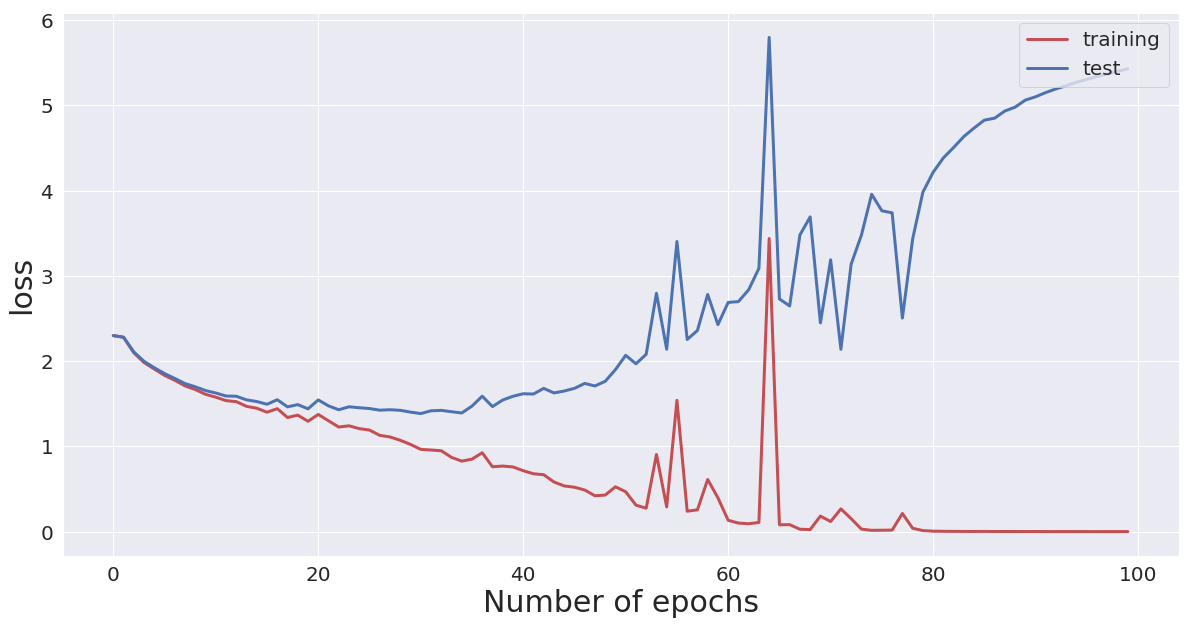

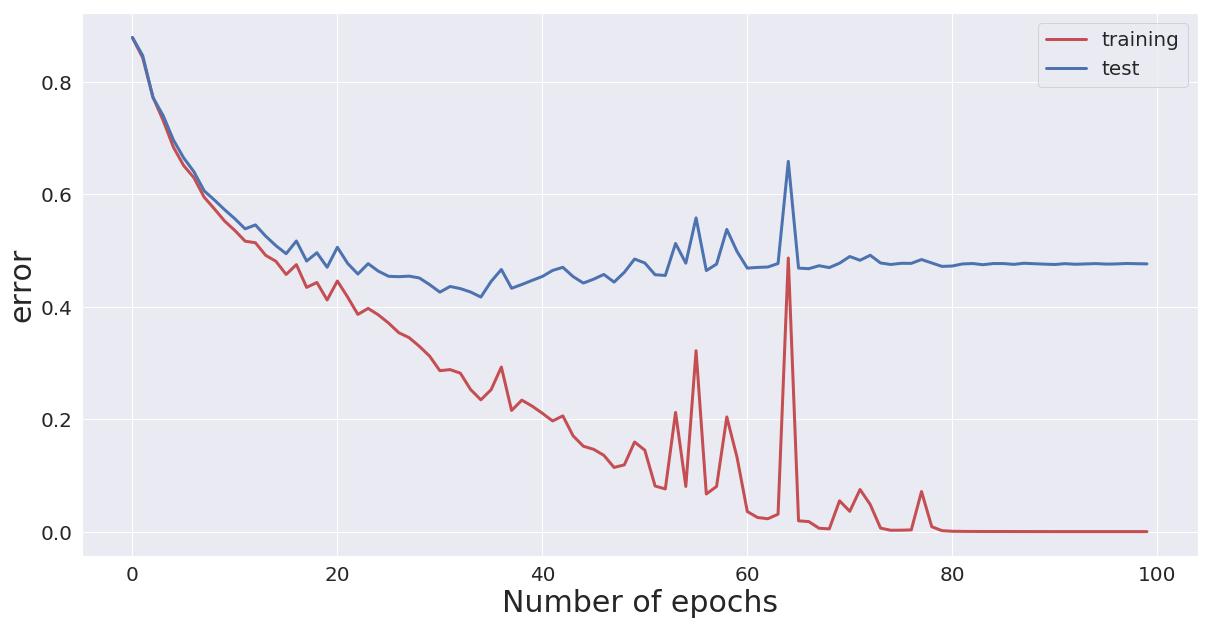

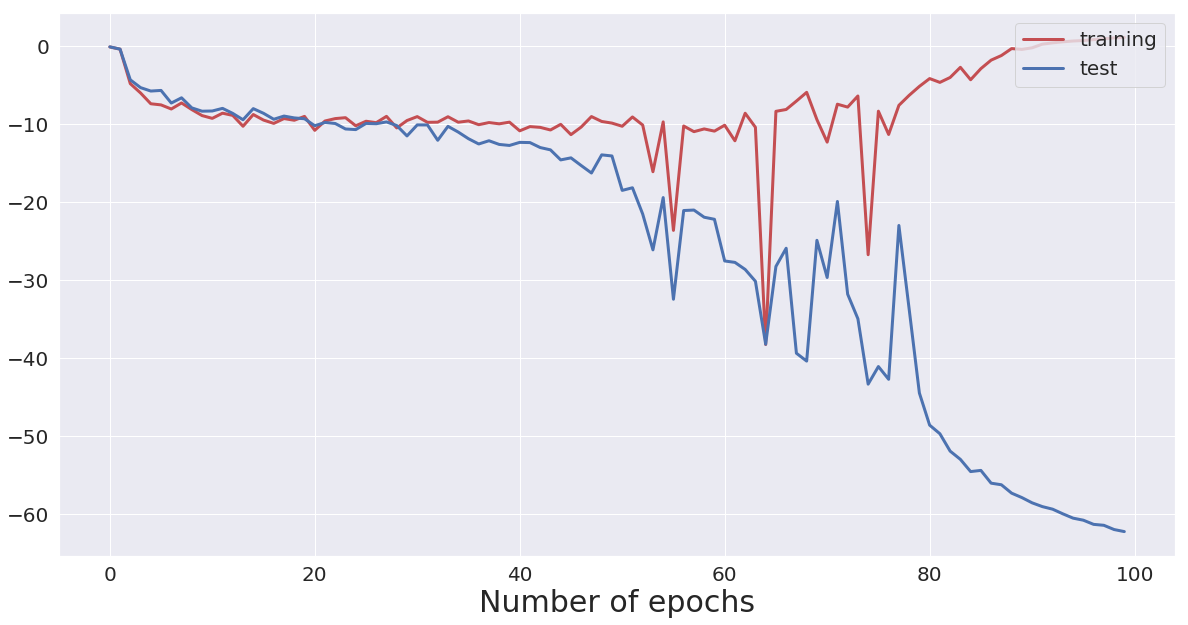

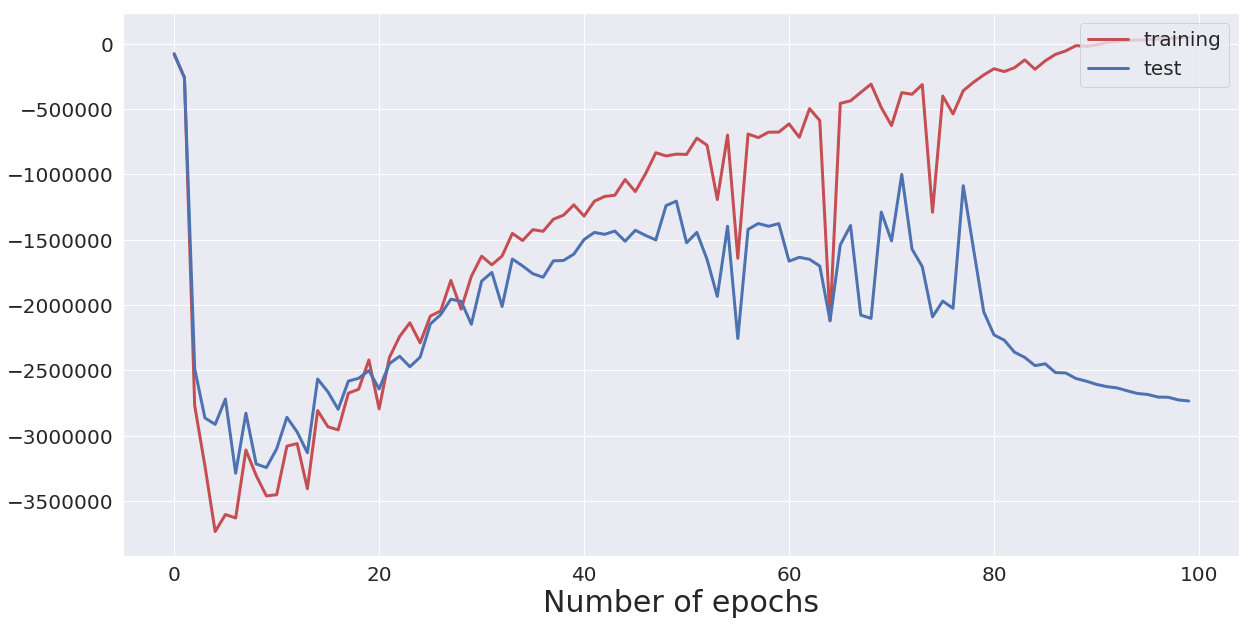

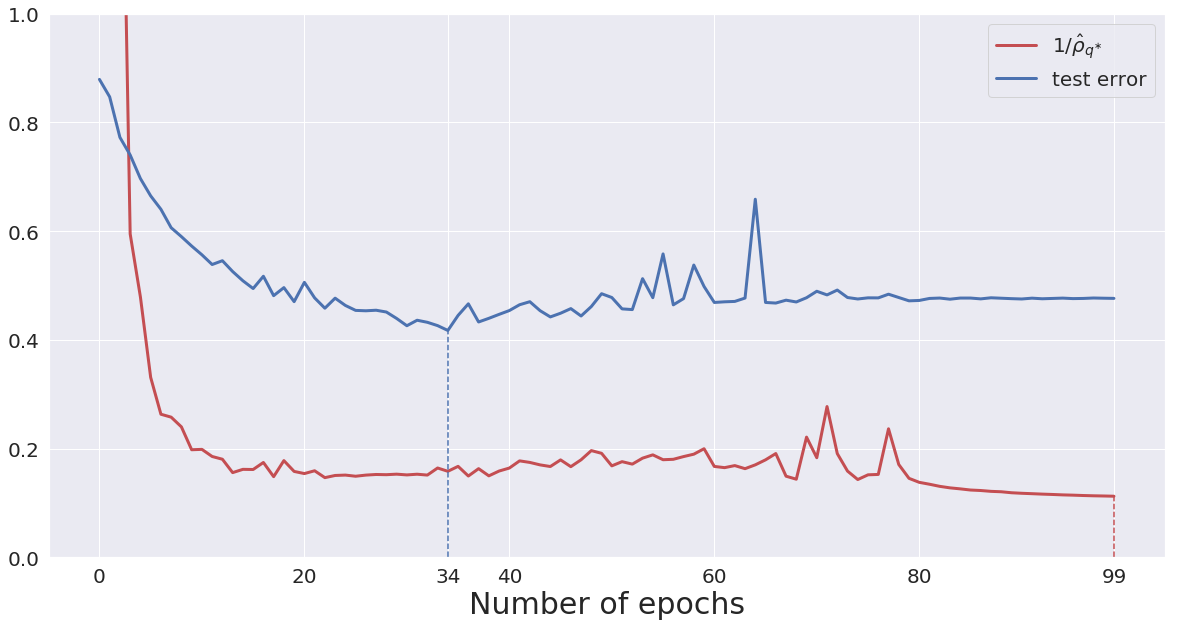

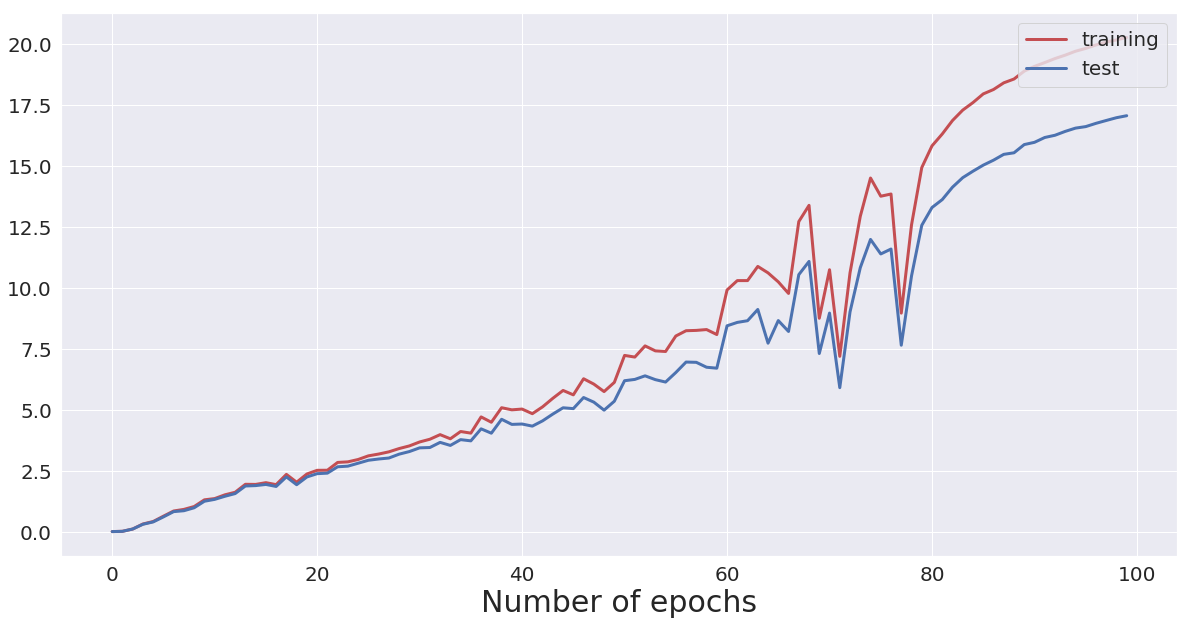

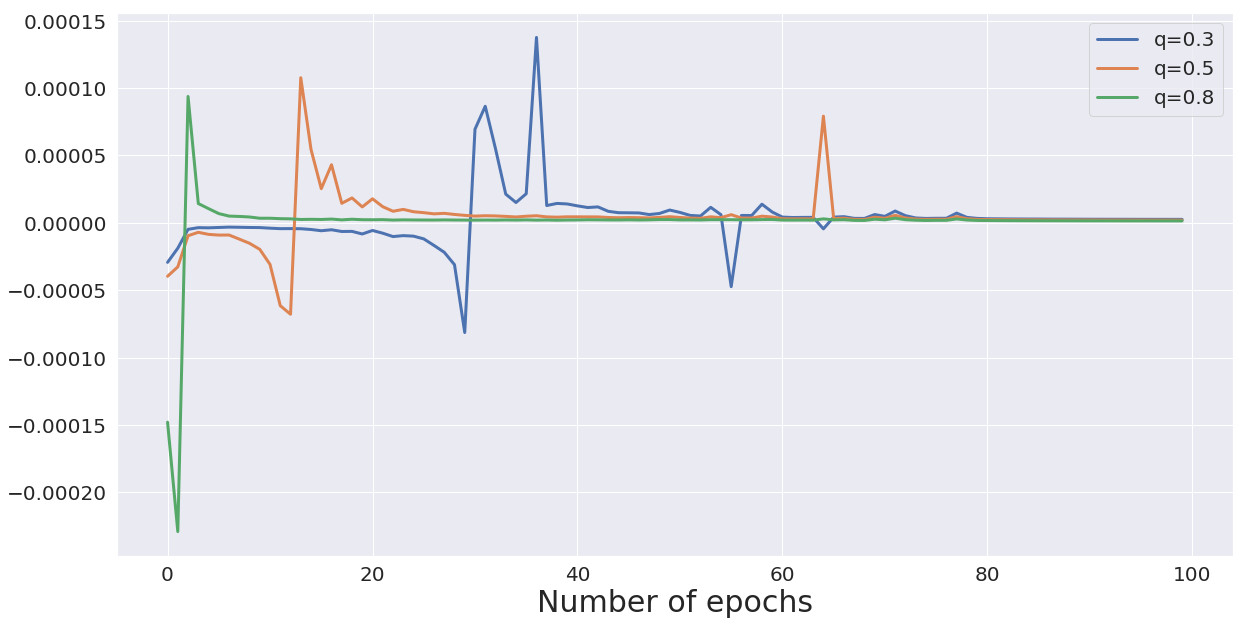

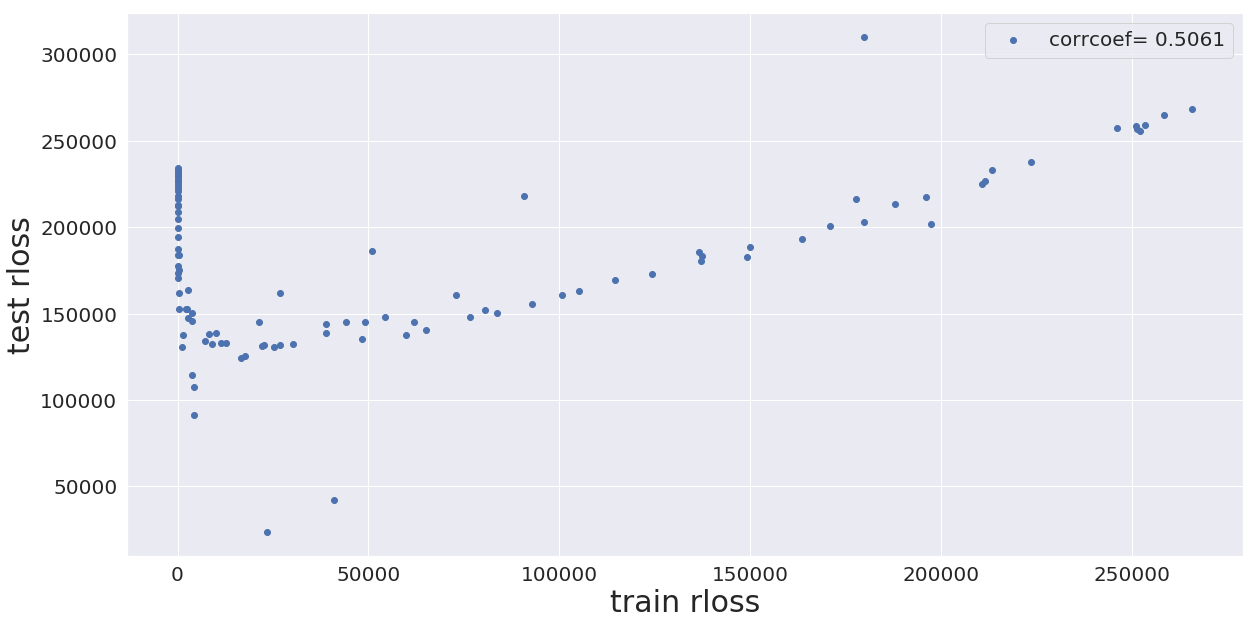

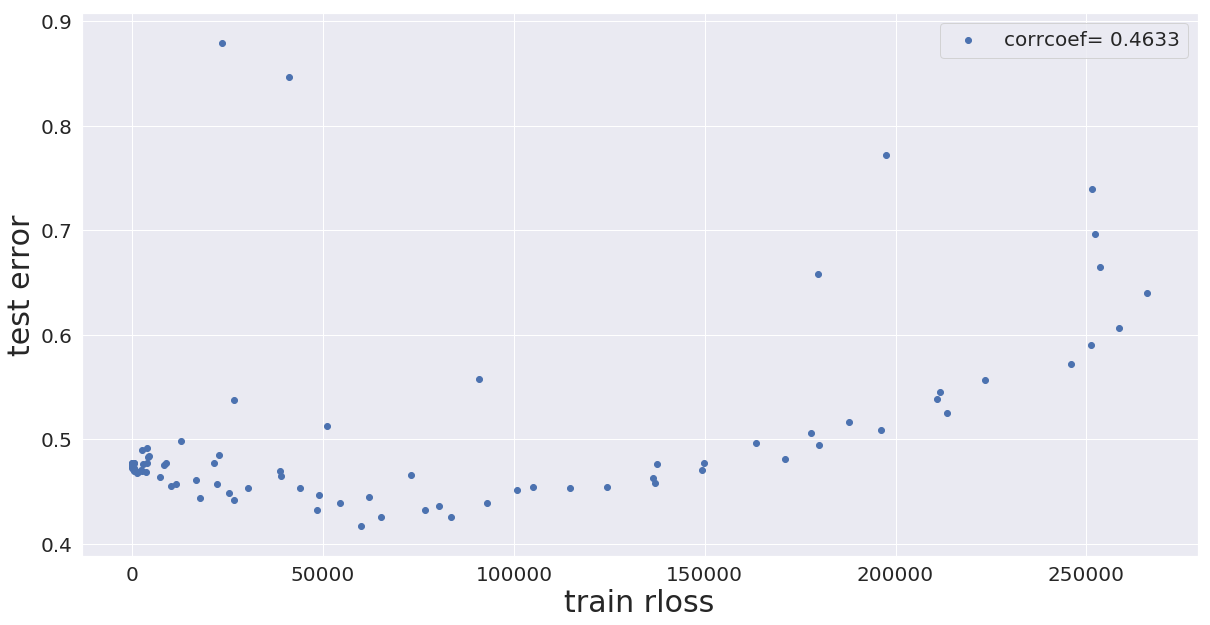

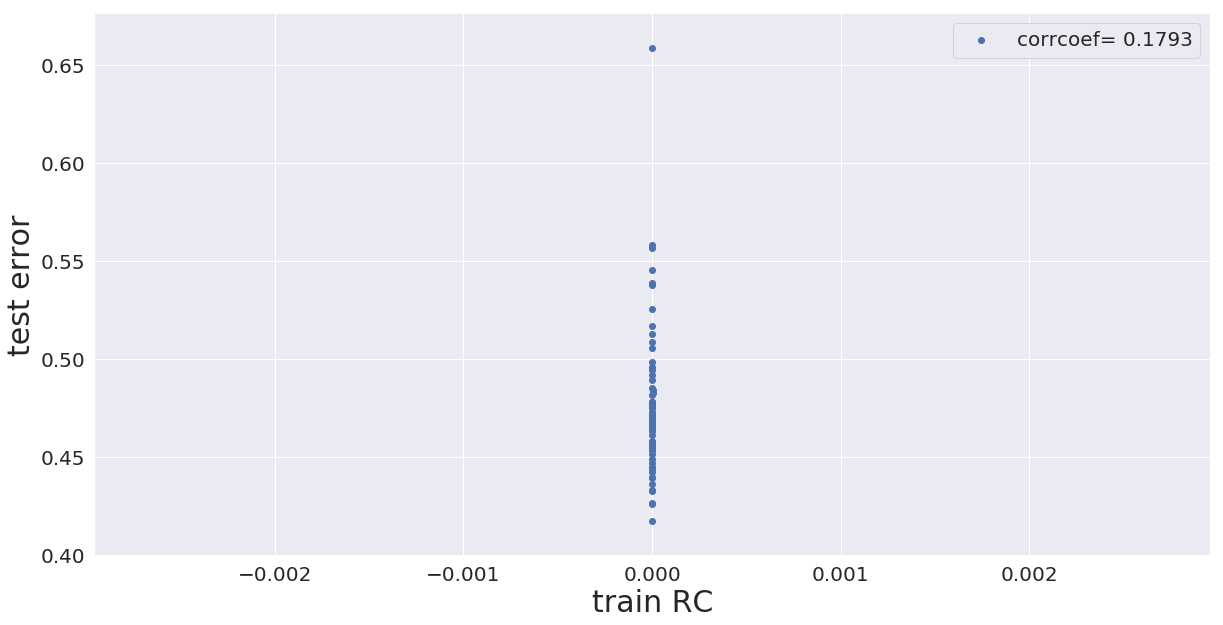

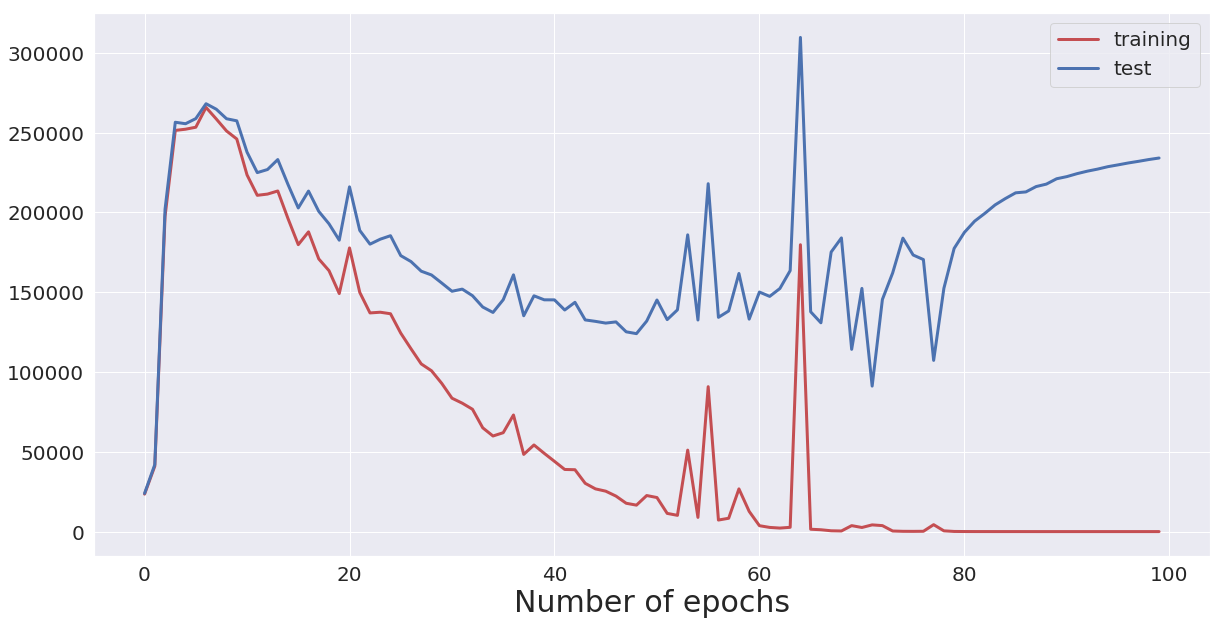

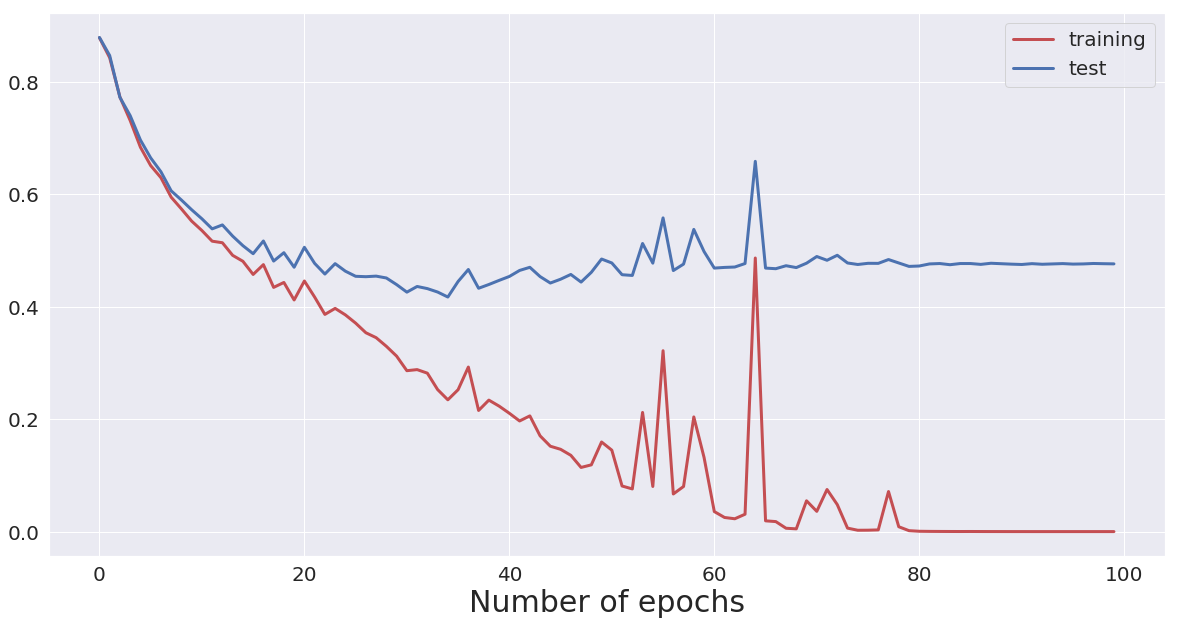

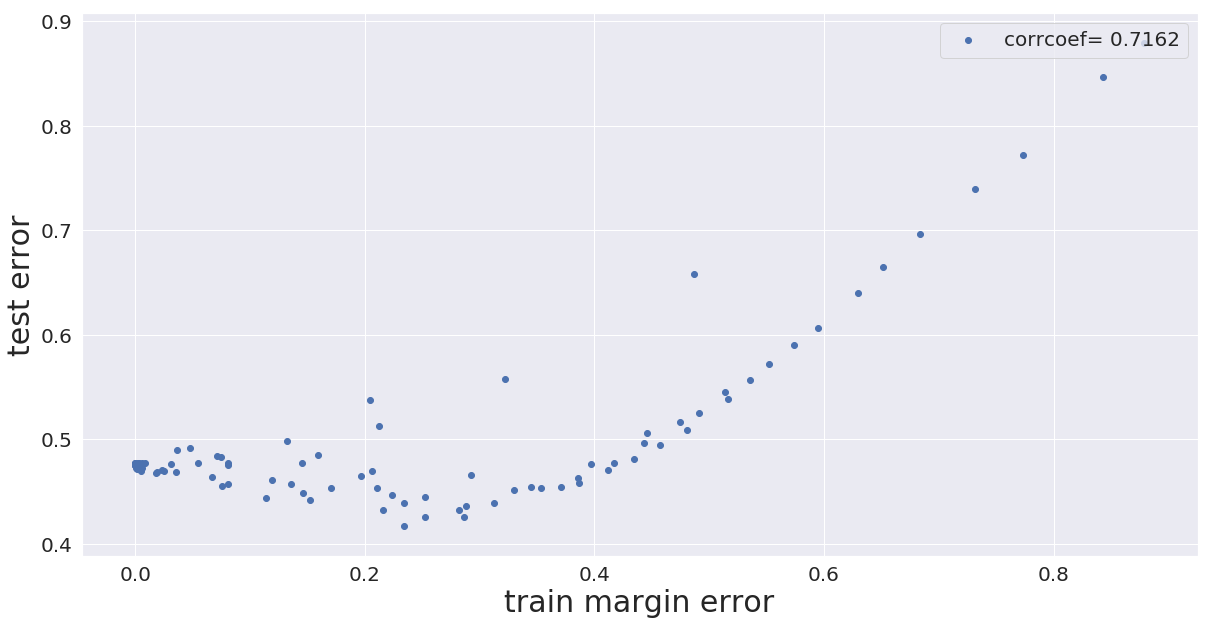

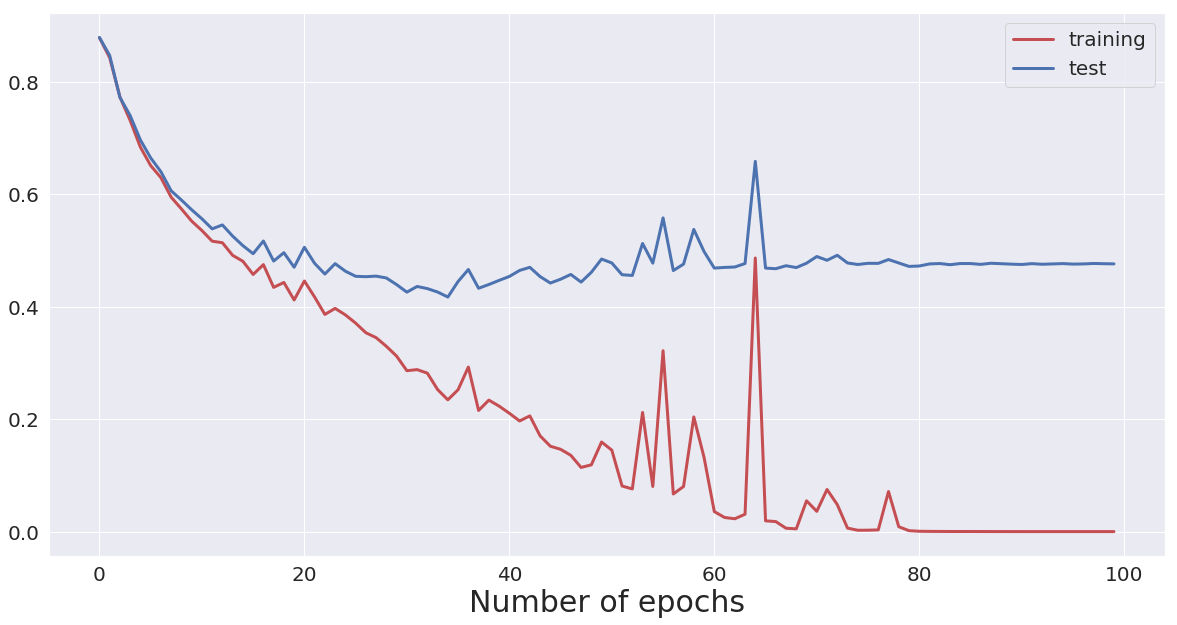

In [40]:
plot(log_1, 0.9, './alex_results_p0.1/')
plt.show()

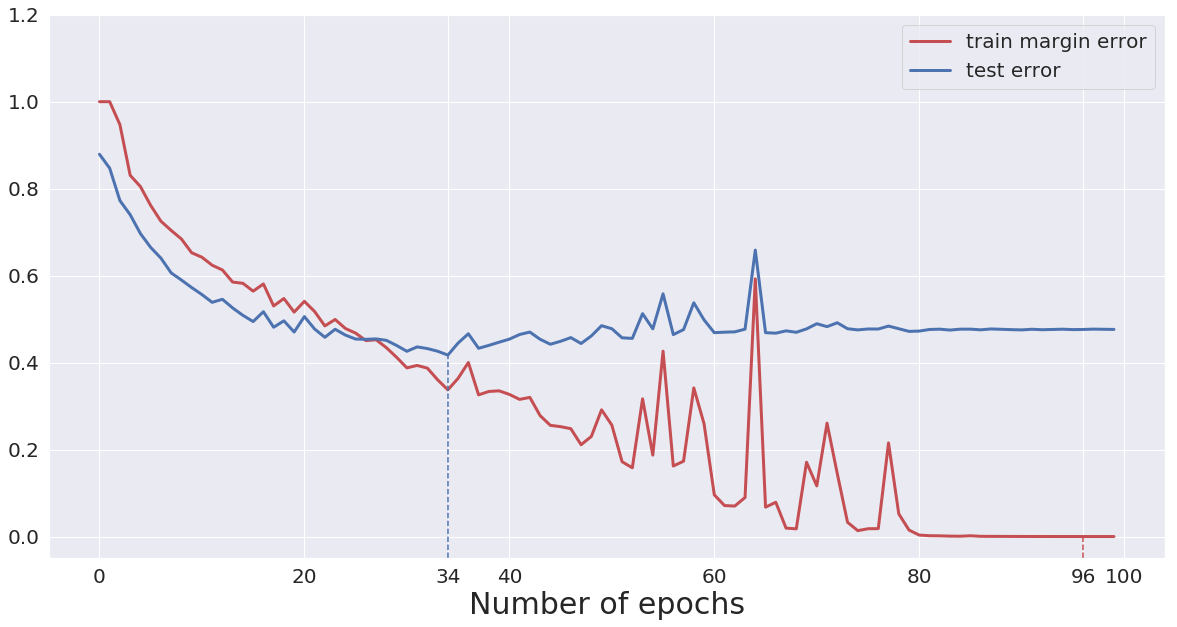

In [42]:
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 1e5) for (margin, lip) in zip(log_1['margin_train'], log_1['Lip'])]
ax.plot(train_merror
    ,'r',linewidth=3,
    label='train margin error')
ax.plot(log_1['test_error'],'b',linewidth=3,label='test error')
ax.legend(fontsize=20,loc='best')
#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1.2)
x1=np.argmin(log_1['test_error'])
ax.plot([x1,x1],[-0.05,log_1['test_error'][x1]],'b--')
x2=np.argmin(train_merror)
ax.plot([x2,x2],[-0.05,train_merror[x2]],'r--')
ax.set_xticks([0,min(x1,x2),max(x1,x2),20,40,60,80,100])
ax.set_xlabel('Number of epochs',fontdict={'size': 30})
fig.savefig('./alex_results_p0.1/margin_error_and_test_error.png')

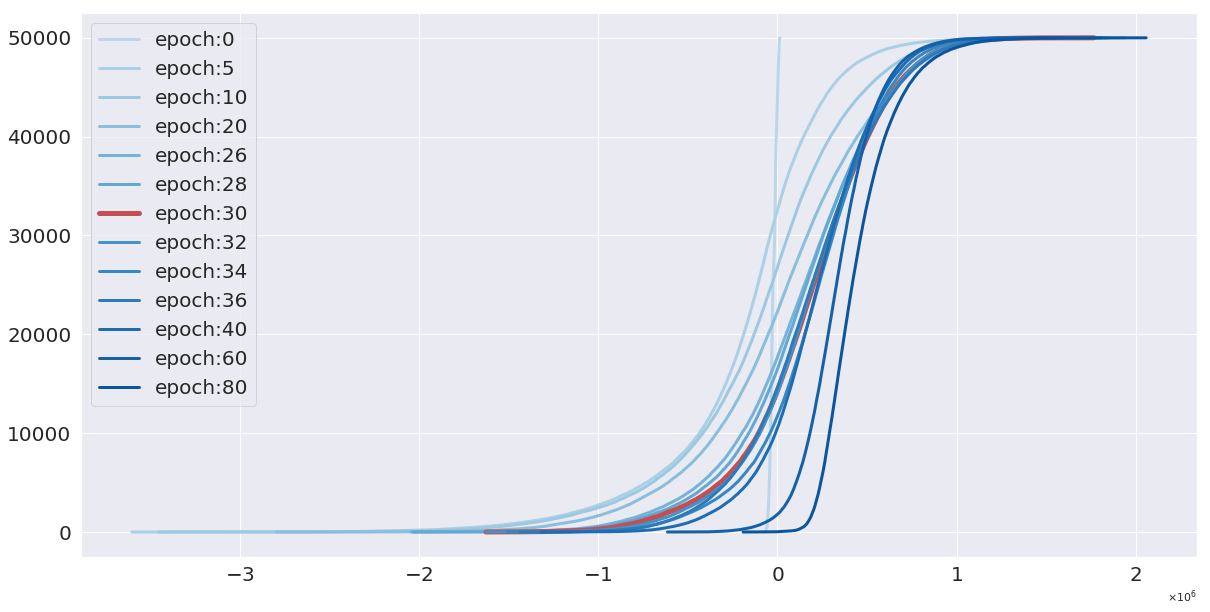

In [43]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,20,26,28,30,32,34,36,40,60, 80]):
    if i==30:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_1['margin_train'][i])/log_1['Lip'][i], range(50000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./alex_results_p0.1/'+'nMargin_distribution.png')

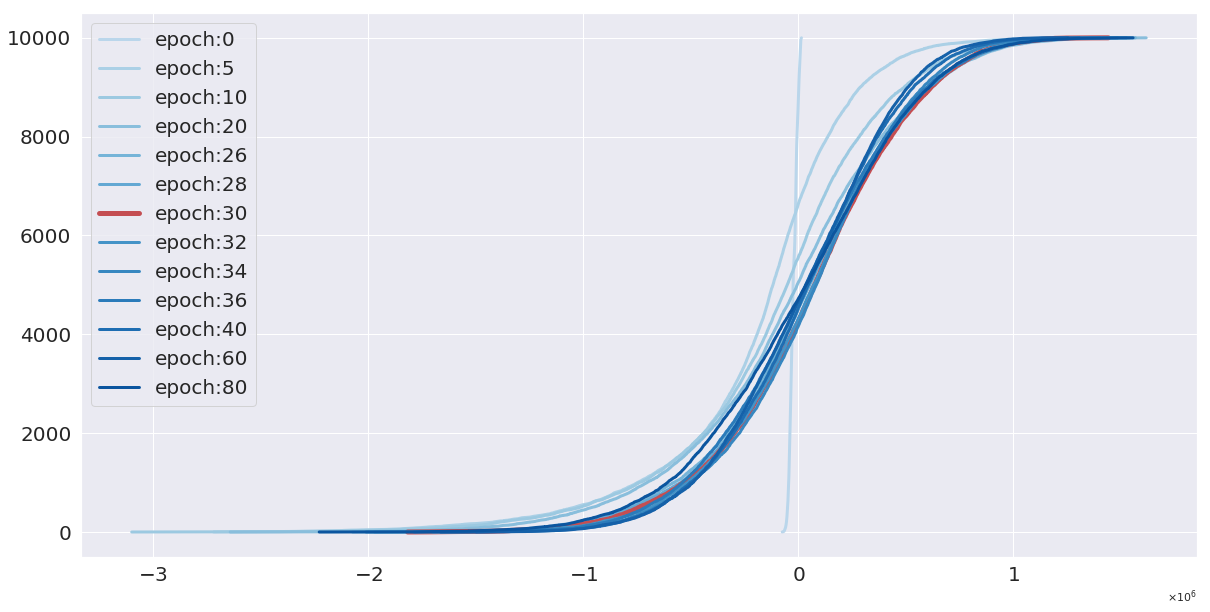

In [44]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,20,26,28,30,32,34,36,40,60, 80]):
    if i==30:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_1['margin_test'][i])/log_1['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
#ax.set_xlim([-20, 70])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./alex_results_p0.1/'+'test_nMargin_distribution.png')

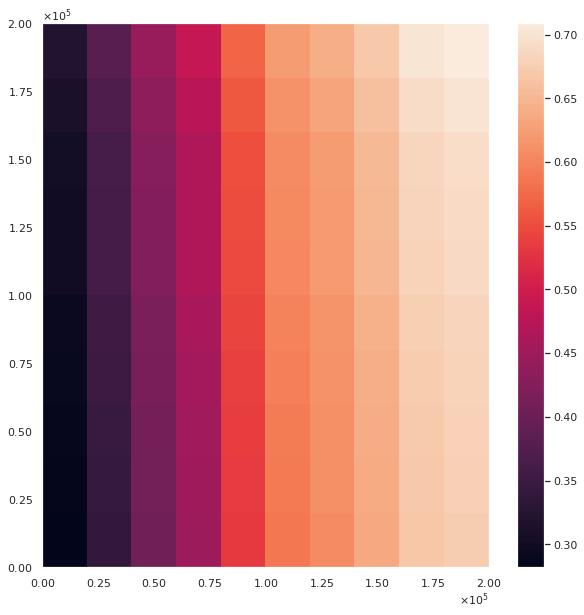

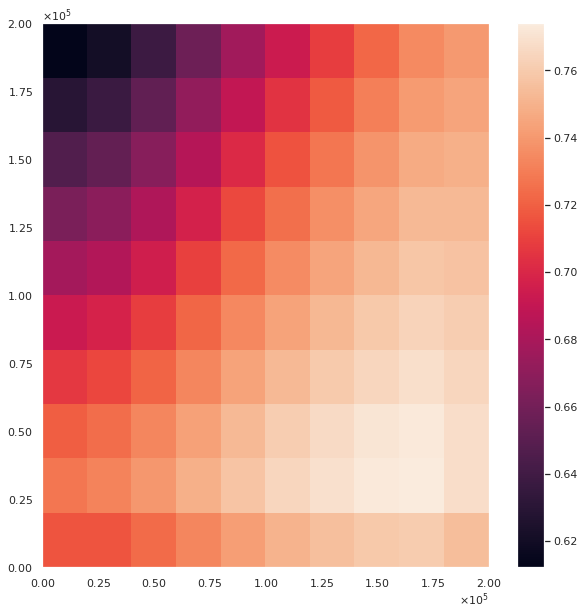

In [45]:
plot_heatmap(log_1,'./alex_results_p0.1/',np.linspace(0,2e5,11))

# Experiment on CIFAR100 with noise=0.1 for Alex

In [4]:
#
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms,'cifar100')

loaders = {'train': training_loader, 'test': testing_loader}

log_cifar100 = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 100
model = alex.alexnet(num_classes=100)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_cifar100['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 2495396


In [5]:
model, log_cifar100 = train_model(
    model, criterion, optimizer, log_cifar100, g0, num_epochs=num_epochs)

Epoch 1/100
----------
train1 Loss: 4.5982 rLoss: 21472.7995 Error: 0.9810 RampLoss: 0.981020 MarginError: 0.9810 Margin: -0.2111 Lip: 4.9875e-06
test Loss: 4.5977 rLoss: 21407.9575 Error: 0.9797 RampLoss: 0.979700 MarginError: 0.9797 Margin: -0.2089 Lip: 4.9875e-06
Saving..
Epoch 2/100
----------
train1 Loss: 4.5865 rLoss: 42900.5879 Error: 0.9799 RampLoss: 0.979940 MarginError: 0.9799 Margin: -0.4430 Lip: 5.0022e-06
test Loss: 4.5864 rLoss: 42979.2633 Error: 0.9806 RampLoss: 0.980600 MarginError: 0.9806 Margin: -0.4467 Lip: 5.0022e-06
Epoch 3/100
----------
train1 Loss: 4.5583 rLoss: 124693.1791 Error: 0.9800 RampLoss: 0.979980 MarginError: 0.9800 Margin: -1.8015 Lip: 5.0399e-06
test Loss: 4.5597 rLoss: 125595.0459 Error: 0.9800 RampLoss: 0.980000 MarginError: 0.9800 Margin: -1.8790 Lip: 5.0399e-06
Epoch 4/100
----------
train1 Loss: 4.5351 rLoss: 124207.8645 Error: 0.9779 RampLoss: 0.977860 MarginError: 0.9779 Margin: -2.3915 Lip: 5.0724e-06
test Loss: 4.5375 rLoss: 125326.5401 Erro

test Loss: 3.2663 rLoss: 150487.5245 Error: 0.7797 RampLoss: 0.779700 MarginError: 0.7797 Margin: -12.4169 Lip: 1.0578e-05
Saving..
Epoch 32/100
----------
train1 Loss: 2.9723 rLoss: 118705.7375 Error: 0.7285 RampLoss: 0.728518 MarginError: 0.7285 Margin: -11.2988 Lip: 1.0916e-05
test Loss: 3.1950 rLoss: 138537.1749 Error: 0.7706 RampLoss: 0.770600 MarginError: 0.7706 Margin: -12.7722 Lip: 1.0916e-05
Epoch 33/100
----------
train1 Loss: 2.9677 rLoss: 120362.1047 Error: 0.7262 RampLoss: 0.726241 MarginError: 0.7263 Margin: -12.0456 Lip: 1.1281e-05
test Loss: 3.2123 rLoss: 141480.8226 Error: 0.7695 RampLoss: 0.769500 MarginError: 0.7695 Margin: -13.4908 Lip: 1.1281e-05
Epoch 34/100
----------
train1 Loss: 2.9049 rLoss: 109215.6815 Error: 0.7110 RampLoss: 0.710980 MarginError: 0.7110 Margin: -11.2171 Lip: 1.1654e-05
test Loss: 3.1571 rLoss: 130321.9850 Error: 0.7591 RampLoss: 0.759100 MarginError: 0.7591 Margin: -12.8193 Lip: 1.1654e-05
Epoch 35/100
----------
train1 Loss: 2.8906 rLoss: 1

Epoch 62/100
----------
train1 Loss: 1.9258 rLoss: 28230.7780 Error: 0.5025 RampLoss: 0.502480 MarginError: 0.5025 Margin: -13.3765 Lip: 3.2925e-05
test Loss: 3.0579 rLoss: 60453.9286 Error: 0.6975 RampLoss: 0.697500 MarginError: 0.6975 Margin: -16.4872 Lip: 3.2925e-05
Epoch 63/100
----------
train1 Loss: 1.9602 rLoss: 28175.8583 Error: 0.5163 RampLoss: 0.516260 MarginError: 0.5163 Margin: -14.0032 Lip: 3.4355e-05
test Loss: 3.0956 rLoss: 58961.3989 Error: 0.7063 RampLoss: 0.706328 MarginError: 0.7064 Margin: -15.0052 Lip: 3.4355e-05
Epoch 64/100
----------
train1 Loss: 1.8089 rLoss: 22865.7484 Error: 0.4695 RampLoss: 0.469480 MarginError: 0.4695 Margin: -13.1698 Lip: 3.5879e-05
test Loss: 3.0051 rLoss: 53785.5855 Error: 0.6896 RampLoss: 0.689600 MarginError: 0.6896 Margin: -16.3258 Lip: 3.5879e-05
Epoch 65/100
----------
train1 Loss: 1.8241 rLoss: 22986.4876 Error: 0.4791 RampLoss: 0.479100 MarginError: 0.4791 Margin: -14.5937 Lip: 3.7503e-05
test Loss: 3.0707 rLoss: 53993.5465 Error:

test Loss: 4.5918 rLoss: 29635.9518 Error: 0.7280 RampLoss: 0.728000 MarginError: 0.7280 Margin: -29.9078 Lip: 1.3560e-04
Epoch 93/100
----------
train1 Loss: 0.4815 rLoss: 1400.3037 Error: 0.1382 RampLoss: 0.138161 MarginError: 0.1382 Margin: -13.9384 Lip: 1.4160e-04
test Loss: 4.7534 rLoss: 30080.5423 Error: 0.7040 RampLoss: 0.704000 MarginError: 0.7040 Margin: -30.4951 Lip: 1.4160e-04
Epoch 94/100
----------
train1 Loss: 0.4089 rLoss: 883.9273 Error: 0.1082 RampLoss: 0.108160 MarginError: 0.1082 Margin: -10.4033 Lip: 1.4764e-04
test Loss: 4.6001 rLoss: 27559.5616 Error: 0.7108 RampLoss: 0.710800 MarginError: 0.7108 Margin: -31.4522 Lip: 1.4764e-04
Epoch 95/100
----------
train1 Loss: 0.3942 rLoss: 858.9101 Error: 0.1057 RampLoss: 0.105740 MarginError: 0.1057 Margin: -11.2881 Lip: 1.5375e-04
test Loss: 4.8078 rLoss: 27990.3011 Error: 0.7171 RampLoss: 0.717100 MarginError: 0.7171 Margin: -32.3132 Lip: 1.5375e-04
Epoch 96/100
----------
train1 Loss: 0.4177 rLoss: 997.0073 Error: 0.1202

In [3]:
import pickle
log_cifar100=pickle.load(open('./alex_results_p0.1/log_cifar100','rb'))

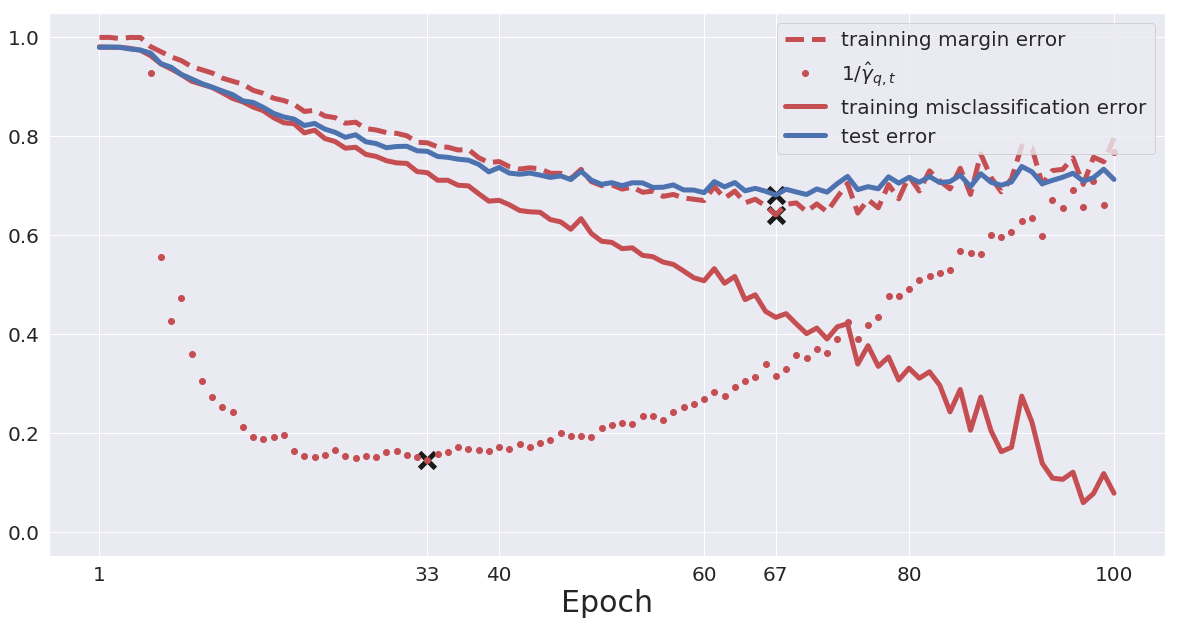

In [20]:
def get_qmargin(margins, q):
    q1 = int(len(margins[0]) * q)
    return [np.partition(margin, q1)[q1] for margin in margins]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip * 3e4) for (margin, lip) in zip(log_cifar100['margin_train'], log_cifar100['Lip'])]
nqMargin_train = np.array(get_qmargin(log_cifar100['margin_train'],
                                                 0.99)) / np.array(log_cifar100['Lip'])*2e-5

ax.plot(train_merror
    ,'r--',linewidth=5,
    label='trainning margin error')
ax.plot(1/nqMargin_train,'ro', linewidth=5, label=r'$1/\hat{\gamma}_{q,t}$')

ax.plot(log_cifar100['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log_cifar100['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1.05)
x1=np.argmin(log_cifar100['test_error'])
ax.scatter(x1,log_cifar100['test_error'][x1],s=250,c='k',marker='x',linewidth=5)
x2=np.argmin(train_merror)
ax.scatter(x2,train_merror[x2],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
#fig.savefig('./results_original/margin_error_and_test_error.png')


x3=np.argmin(1/nqMargin_train)
ax.scatter(x3,1/nqMargin_train[x3],s=250,c='k',marker='x',linewidth=5)
ax.set_xticks([0,x1,x2,x3,39,59,79,99])
ax.set_xticklabels([1,x1+1,'',x3+1,40,60,80,100])
ax.legend(loc='upper right',fontsize=20)
#plt.show()
fig.savefig('./alex_results_p0.1/cifar100_margin_error_and_test_error.png')

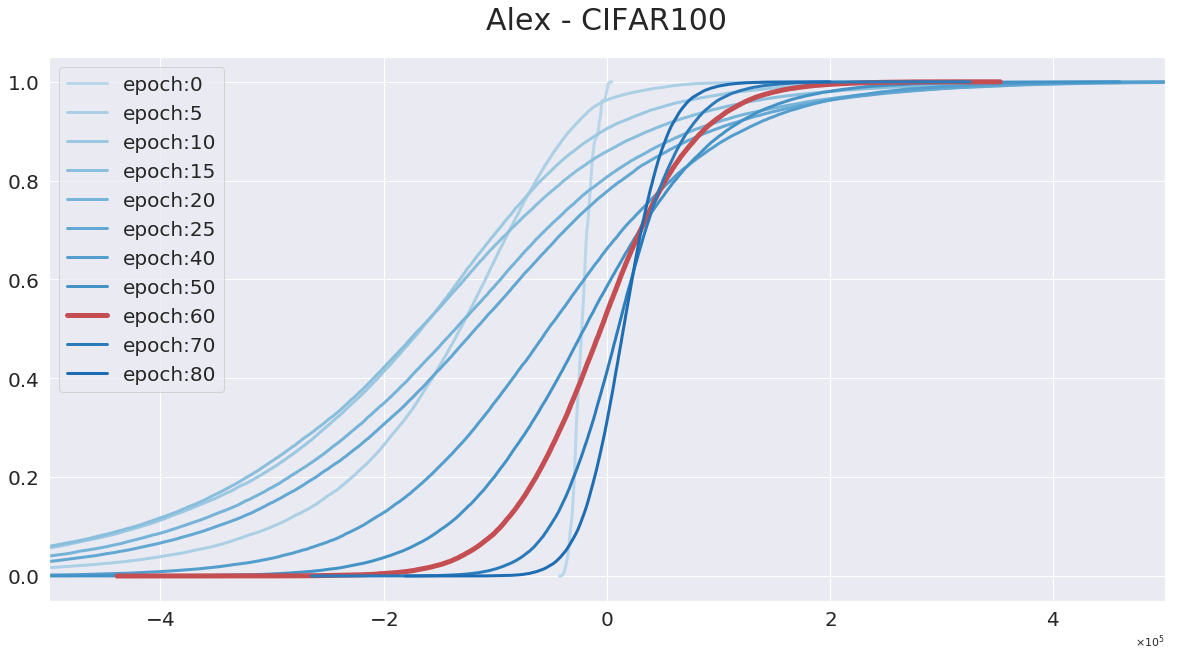

In [23]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('Alex - CIFAR100', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,15,20,25, 40,50,60,70, 80]):
    if i==60:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_cifar100['margin_train'][i])/log_cifar100['Lip'][i], np.arange(50000)/50000,c=c, label=f'epoch:{i}',linewidth=d)
ax.set_xlim([-5e5, 5e5])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./alex_results_p0.1/'+'cifar100_nMargin_distribution.png')

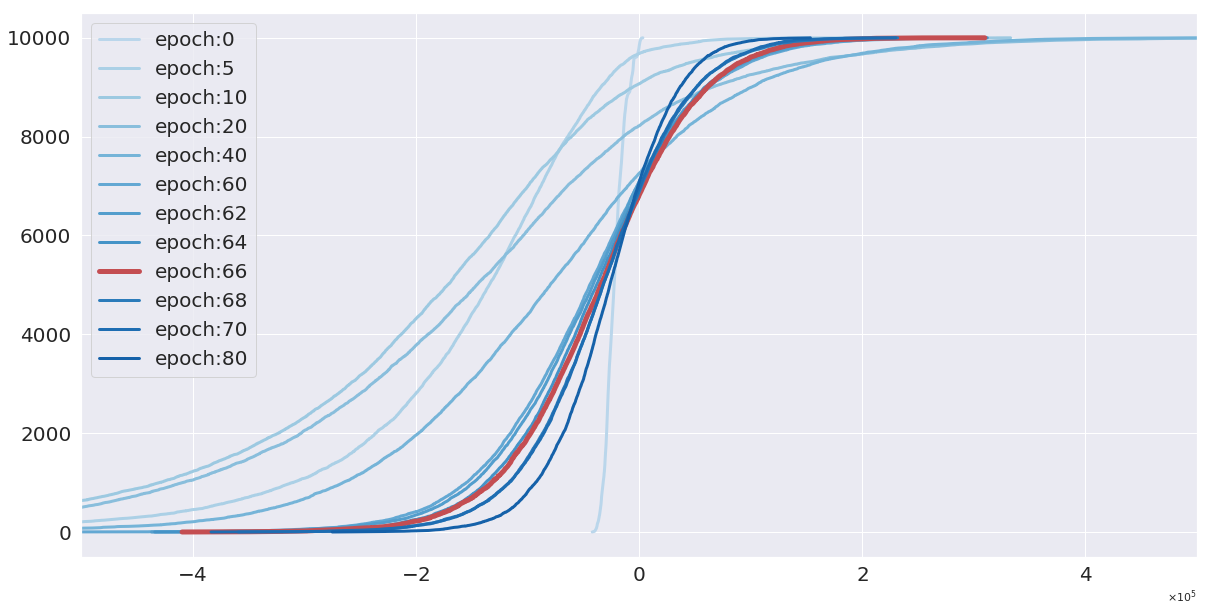

In [20]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0, 5, 10,20, 40,60,62,64,66,68,70, 80]):
    if i==66:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_cifar100['margin_test'][i])/log_cifar100['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
ax.set_xlim([-5e5, 5e5])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./alex_results_p0.1/'+'cifar100_test_nMargin_distribution.png')

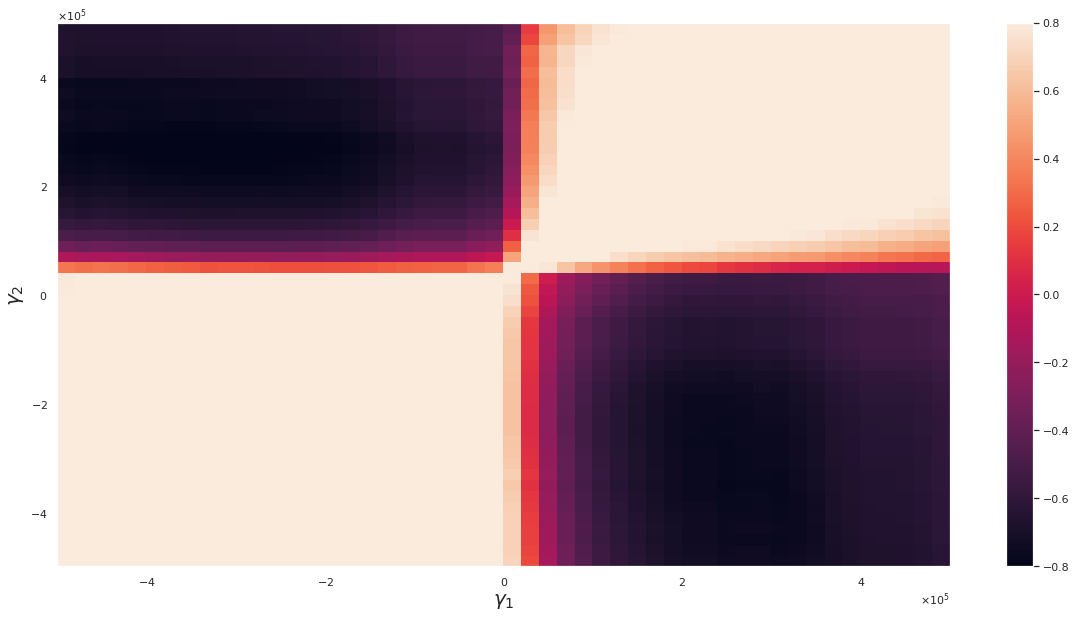

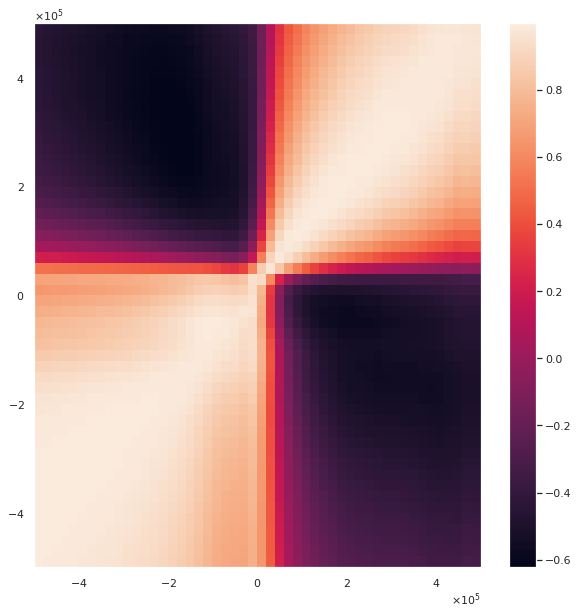

In [25]:
plot_heatmap(log_cifar100,'./alex_results_p0.1/cifar100_',np.linspace(-5e5,5e5,51))

In [21]:
import pickle
pickle.dump(log_cifar100,open('./alex_results_p0.1/log_cifar100','wb'))

# Experiment on MiniImageNet with noise=0.1 for Alex

In [4]:
#
root = '/home/share/DataSets/data_miniImageNet.h5'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.
label_mode = 'partially-0.1'
g0 = 1

print(f'****** label mode: {label_mode} ******')

img_transforms = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
(training_dataset, testing_dataset), \
(training_loader, testing_loader) = get_loader(root, BATCH_SIZE, label_mode, img_transforms,'miniImageNet')

loaders = {'train': training_loader, 'test': testing_loader}

log_mini = {
    'num_params': [],
    'train_loss': [],
    'train_rloss': [],
    'train_error': [],
    'train_margin_error': [],
    'train_ramp_loss': [],
    'test_ramp_loss': [],
    'test_loss': [],
    'test_rloss': [],
    'test_error': [],
    'test_margin_error': [],
    'Lip': [],
    'margin_train': [],
    'margin_test': []
}

# %% run the model
num_epochs = 600
model = alex.alexnet(num_classes=100)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'total parameters: {number_params}')

log_mini['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

****** label mode: partially-0.1 ******


/home/yhuangcc/.conda/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


total parameters: 2495396


In [5]:
model, log_mini = train_model(
    model, criterion, optimizer, log_mini, g0, num_epochs=num_epochs)

Epoch 1/600
----------
train1 Loss: 4.6051 rLoss: 13320.8023 Error: 0.9889 RampLoss: 0.988923 MarginError: 0.9889 Margin: -0.1529 Lip: 4.9938e-06
test Loss: 4.6055 rLoss: 13404.2256 Error: 0.9889 RampLoss: 0.988900 MarginError: 0.9889 Margin: -0.1489 Lip: 4.9938e-06
Saving..
Epoch 2/600
----------
train1 Loss: 4.6043 rLoss: 13019.3802 Error: 0.9882 RampLoss: 0.988180 MarginError: 0.9882 Margin: -0.1489 Lip: 4.9961e-06
test Loss: 4.6049 rLoss: 13138.7364 Error: 0.9888 RampLoss: 0.988800 MarginError: 0.9888 Margin: -0.1484 Lip: 4.9961e-06
Epoch 3/600
----------
train1 Loss: 4.6033 rLoss: 13086.3996 Error: 0.9879 RampLoss: 0.987940 MarginError: 0.9879 Margin: -0.1606 Lip: 5.0006e-06
test Loss: 4.6041 rLoss: 13238.4466 Error: 0.9878 RampLoss: 0.987800 MarginError: 0.9878 Margin: -0.1570 Lip: 5.0006e-06
Epoch 4/600
----------
train1 Loss: 4.6016 rLoss: 14019.3049 Error: 0.9871 RampLoss: 0.987080 MarginError: 0.9871 Margin: -0.2024 Lip: 5.0081e-06
test Loss: 4.6027 rLoss: 14209.5674 Error: 0

test Loss: 4.0937 rLoss: 194120.0119 Error: 0.9082 RampLoss: 0.908200 MarginError: 0.9082 Margin: -9.7209 Lip: 6.6654e-06
Saving..
Epoch 32/600
----------
train1 Loss: 4.0518 rLoss: 189224.7286 Error: 0.9024 RampLoss: 0.902380 MarginError: 0.9024 Margin: -9.6133 Lip: 6.7564e-06
test Loss: 4.0806 rLoss: 192097.6242 Error: 0.9095 RampLoss: 0.909500 MarginError: 0.9095 Margin: -9.5804 Lip: 6.7564e-06
Epoch 33/600
----------
train1 Loss: 4.0376 rLoss: 183697.8700 Error: 0.9017 RampLoss: 0.901680 MarginError: 0.9017 Margin: -10.1004 Lip: 6.8422e-06
test Loss: 4.0746 rLoss: 187246.6886 Error: 0.9027 RampLoss: 0.902700 MarginError: 0.9027 Margin: -9.2693 Lip: 6.8422e-06
Epoch 34/600
----------
train1 Loss: 4.0210 rLoss: 187597.0978 Error: 0.8988 RampLoss: 0.898780 MarginError: 0.8988 Margin: -10.8396 Lip: 6.9389e-06
test Loss: 4.0530 rLoss: 190649.1517 Error: 0.9023 RampLoss: 0.902300 MarginError: 0.9023 Margin: -10.8753 Lip: 6.9389e-06
Epoch 35/600
----------
train1 Loss: 4.0086 rLoss: 19428

Epoch 62/600
----------
train1 Loss: 3.6487 rLoss: 137471.3511 Error: 0.8279 RampLoss: 0.827880 MarginError: 0.8279 Margin: -10.8736 Lip: 1.0748e-05
test Loss: 3.7401 rLoss: 144479.6773 Error: 0.8408 RampLoss: 0.840800 MarginError: 0.8408 Margin: -10.7455 Lip: 1.0748e-05
Epoch 63/600
----------
train1 Loss: 3.6342 rLoss: 135934.4656 Error: 0.8267 RampLoss: 0.826700 MarginError: 0.8267 Margin: -11.7058 Lip: 1.0921e-05
test Loss: 3.7202 rLoss: 142918.1482 Error: 0.8384 RampLoss: 0.838400 MarginError: 0.8384 Margin: -11.1287 Lip: 1.0921e-05
Epoch 64/600
----------
train1 Loss: 3.6678 rLoss: 140043.8245 Error: 0.8313 RampLoss: 0.831300 MarginError: 0.8313 Margin: -11.3227 Lip: 1.1096e-05
test Loss: 3.7569 rLoss: 146935.2969 Error: 0.8463 RampLoss: 0.846300 MarginError: 0.8463 Margin: -11.1714 Lip: 1.1096e-05
Epoch 65/600
----------
train1 Loss: 3.6191 rLoss: 133418.9116 Error: 0.8243 RampLoss: 0.824280 MarginError: 0.8243 Margin: -10.2373 Lip: 1.1267e-05
test Loss: 3.7167 rLoss: 140857.524

test Loss: 3.5770 rLoss: 100268.1399 Error: 0.8067 RampLoss: 0.806700 MarginError: 0.8067 Margin: -11.1315 Lip: 1.7113e-05
Epoch 93/600
----------
train1 Loss: 3.4312 rLoss: 90070.2501 Error: 0.7864 RampLoss: 0.786440 MarginError: 0.7864 Margin: -10.9214 Lip: 1.7381e-05
test Loss: 3.5953 rLoss: 99328.3557 Error: 0.8064 RampLoss: 0.806400 MarginError: 0.8064 Margin: -11.8095 Lip: 1.7381e-05
Epoch 94/600
----------
train1 Loss: 3.3794 rLoss: 88328.7228 Error: 0.7794 RampLoss: 0.779360 MarginError: 0.7794 Margin: -12.3676 Lip: 1.7656e-05
test Loss: 3.5686 rLoss: 98230.0019 Error: 0.8052 RampLoss: 0.805200 MarginError: 0.8052 Margin: -12.3124 Lip: 1.7656e-05
Epoch 95/600
----------
train1 Loss: 3.3732 rLoss: 86669.8726 Error: 0.7751 RampLoss: 0.775100 MarginError: 0.7751 Margin: -11.5101 Lip: 1.7927e-05
test Loss: 3.5495 rLoss: 95754.0674 Error: 0.7979 RampLoss: 0.797900 MarginError: 0.7979 Margin: -14.0694 Lip: 1.7927e-05
Epoch 96/600
----------
train1 Loss: 3.3666 rLoss: 84788.7006 Error

train1 Loss: 3.1605 rLoss: 54652.8741 Error: 0.7348 RampLoss: 0.734780 MarginError: 0.7348 Margin: -13.3271 Lip: 2.7587e-05
test Loss: 3.4583 rLoss: 64376.7719 Error: 0.7719 RampLoss: 0.771900 MarginError: 0.7719 Margin: -12.8620 Lip: 2.7587e-05
Epoch 124/600
----------
train1 Loss: 3.1798 rLoss: 51457.0839 Error: 0.7410 RampLoss: 0.741040 MarginError: 0.7410 Margin: -11.6365 Lip: 2.8028e-05
test Loss: 3.4887 rLoss: 61724.4207 Error: 0.7860 RampLoss: 0.786000 MarginError: 0.7860 Margin: -13.1369 Lip: 2.8028e-05
Epoch 125/600
----------
train1 Loss: 3.1547 rLoss: 51190.9802 Error: 0.7333 RampLoss: 0.733312 MarginError: 0.7333 Margin: -11.0194 Lip: 2.8470e-05
test Loss: 3.4776 rLoss: 61665.5007 Error: 0.7837 RampLoss: 0.783700 MarginError: 0.7837 Margin: -13.8024 Lip: 2.8470e-05
Epoch 126/600
----------
train1 Loss: 3.1359 rLoss: 47979.8182 Error: 0.7295 RampLoss: 0.729480 MarginError: 0.7295 Margin: -10.4030 Lip: 2.8911e-05
test Loss: 3.4626 rLoss: 58553.6075 Error: 0.7758 RampLoss: 0.7

test Loss: 3.4668 rLoss: 43048.5504 Error: 0.7638 RampLoss: 0.763800 MarginError: 0.7638 Margin: -16.5157 Lip: 4.4427e-05
Epoch 154/600
----------
train1 Loss: 2.9518 rLoss: 31758.3971 Error: 0.6955 RampLoss: 0.695480 MarginError: 0.6955 Margin: -12.2424 Lip: 4.5163e-05
test Loss: 3.4777 rLoss: 42588.4073 Error: 0.7675 RampLoss: 0.767500 MarginError: 0.7675 Margin: -15.6961 Lip: 4.5163e-05
Epoch 155/600
----------
train1 Loss: 2.9396 rLoss: 30025.5772 Error: 0.6926 RampLoss: 0.692626 MarginError: 0.6926 Margin: -10.7443 Lip: 4.5905e-05
test Loss: 3.4564 rLoss: 40533.1780 Error: 0.7654 RampLoss: 0.765400 MarginError: 0.7654 Margin: -13.0948 Lip: 4.5905e-05
Epoch 156/600
----------
train1 Loss: 2.9250 rLoss: 30558.6200 Error: 0.6881 RampLoss: 0.688100 MarginError: 0.6881 Margin: -10.4552 Lip: 4.6635e-05
test Loss: 3.4685 rLoss: 41420.9852 Error: 0.7678 RampLoss: 0.767857 MarginError: 0.7679 Margin: -14.7162 Lip: 4.6635e-05
Epoch 157/600
----------
train1 Loss: 2.9229 rLoss: 31671.4565 Er

train1 Loss: 2.6926 rLoss: 17437.8656 Error: 0.6424 RampLoss: 0.642440 MarginError: 0.6424 Margin: -11.3818 Lip: 7.4270e-05
test Loss: 3.4897 rLoss: 27364.6754 Error: 0.7619 RampLoss: 0.761985 MarginError: 0.7620 Margin: -17.0448 Lip: 7.4270e-05
Epoch 185/600
----------
train1 Loss: 2.7168 rLoss: 18474.9362 Error: 0.6483 RampLoss: 0.648285 MarginError: 0.6483 Margin: -12.1108 Lip: 7.5580e-05
test Loss: 3.5377 rLoss: 28597.6764 Error: 0.7615 RampLoss: 0.761500 MarginError: 0.7615 Margin: -18.3594 Lip: 7.5580e-05
Epoch 186/600
----------
train1 Loss: 2.6950 rLoss: 17603.0273 Error: 0.6411 RampLoss: 0.641119 MarginError: 0.6411 Margin: -11.2164 Lip: 7.6819e-05
test Loss: 3.5392 rLoss: 27837.2810 Error: 0.7662 RampLoss: 0.766200 MarginError: 0.7662 Margin: -19.1003 Lip: 7.6819e-05
Epoch 187/600
----------
train1 Loss: 2.6853 rLoss: 17374.1290 Error: 0.6401 RampLoss: 0.640100 MarginError: 0.6401 Margin: -12.8479 Lip: 7.8151e-05
test Loss: 3.5159 rLoss: 27295.1357 Error: 0.7609 RampLoss: 0.7

test Loss: 3.6031 rLoss: 18630.0905 Error: 0.7598 RampLoss: 0.759800 MarginError: 0.7598 Margin: -23.1027 Lip: 1.2300e-04
Epoch 215/600
----------
train1 Loss: 2.4184 rLoss: 9822.3145 Error: 0.5853 RampLoss: 0.585260 MarginError: 0.5853 Margin: -13.2440 Lip: 1.2519e-04
test Loss: 3.6403 rLoss: 18868.4299 Error: 0.7647 RampLoss: 0.764700 MarginError: 0.7647 Margin: -20.6688 Lip: 1.2519e-04
Epoch 216/600
----------
train1 Loss: 2.4141 rLoss: 9859.6423 Error: 0.5810 RampLoss: 0.581037 MarginError: 0.5810 Margin: -12.2624 Lip: 1.2725e-04
test Loss: 3.6030 rLoss: 18501.8859 Error: 0.7578 RampLoss: 0.757800 MarginError: 0.7578 Margin: -26.3858 Lip: 1.2725e-04
Epoch 217/600
----------
train1 Loss: 2.3948 rLoss: 9381.3185 Error: 0.5776 RampLoss: 0.577603 MarginError: 0.5776 Margin: -12.9476 Lip: 1.2939e-04
test Loss: 3.6180 rLoss: 18145.8953 Error: 0.7632 RampLoss: 0.763200 MarginError: 0.7632 Margin: -21.3586 Lip: 1.2939e-04
Epoch 218/600
----------
train1 Loss: 2.3927 rLoss: 9355.0270 Error:

train1 Loss: 2.1568 rLoss: 5434.0593 Error: 0.5200 RampLoss: 0.519980 MarginError: 0.5200 Margin: -15.3349 Lip: 2.0244e-04
test Loss: 3.7412 rLoss: 12599.5086 Error: 0.7639 RampLoss: 0.763900 MarginError: 0.7639 Margin: -21.3106 Lip: 2.0244e-04
Epoch 246/600
----------
train1 Loss: 2.1489 rLoss: 5323.4248 Error: 0.5210 RampLoss: 0.521058 MarginError: 0.5211 Margin: -14.8810 Lip: 2.0557e-04
test Loss: 3.7245 rLoss: 12392.1308 Error: 0.7599 RampLoss: 0.759969 MarginError: 0.7600 Margin: -22.1976 Lip: 2.0557e-04
Epoch 247/600
----------
train1 Loss: 2.1603 rLoss: 5438.0303 Error: 0.5211 RampLoss: 0.521135 MarginError: 0.5211 Margin: -14.5465 Lip: 2.0876e-04
test Loss: 3.8013 rLoss: 12672.5506 Error: 0.7654 RampLoss: 0.765400 MarginError: 0.7654 Margin: -26.7753 Lip: 2.0876e-04
Epoch 248/600
----------
train1 Loss: 2.1476 rLoss: 5099.1633 Error: 0.5189 RampLoss: 0.518918 MarginError: 0.5189 Margin: -12.8200 Lip: 2.1194e-04
test Loss: 3.7501 rLoss: 12064.0555 Error: 0.7632 RampLoss: 0.76328

test Loss: 3.9485 rLoss: 9161.1926 Error: 0.7709 RampLoss: 0.771008 MarginError: 0.7711 Margin: -29.9138 Lip: 3.1267e-04
Epoch 276/600
----------
train1 Loss: 1.9224 rLoss: 3266.7495 Error: 0.4660 RampLoss: 0.466090 MarginError: 0.4661 Margin: -16.3304 Lip: 3.1675e-04
test Loss: 3.9738 rLoss: 9217.4705 Error: 0.7683 RampLoss: 0.768300 MarginError: 0.7683 Margin: -21.9853 Lip: 3.1675e-04
Epoch 277/600
----------
train1 Loss: 1.9074 rLoss: 3221.9356 Error: 0.4586 RampLoss: 0.458631 MarginError: 0.4587 Margin: -14.5696 Lip: 3.2115e-04
test Loss: 3.9471 rLoss: 9043.4190 Error: 0.7598 RampLoss: 0.759800 MarginError: 0.7598 Margin: -26.6835 Lip: 3.2115e-04
Epoch 278/600
----------
train1 Loss: 1.9073 rLoss: 3042.9133 Error: 0.4567 RampLoss: 0.456766 MarginError: 0.4568 Margin: -17.1500 Lip: 3.2531e-04
test Loss: 3.9470 rLoss: 8772.2501 Error: 0.7725 RampLoss: 0.772500 MarginError: 0.7725 Margin: -21.6453 Lip: 3.2531e-04
Epoch 279/600
----------
train1 Loss: 1.9177 rLoss: 3132.4321 Error: 0.4

train1 Loss: 1.7493 rLoss: 2096.4545 Error: 0.4181 RampLoss: 0.418169 MarginError: 0.4182 Margin: -16.3954 Lip: 4.5910e-04
test Loss: 4.0918 rLoss: 6748.3125 Error: 0.7730 RampLoss: 0.773100 MarginError: 0.7732 Margin: -36.5312 Lip: 4.5910e-04
Epoch 307/600
----------
train1 Loss: 1.7664 rLoss: 2040.0224 Error: 0.4238 RampLoss: 0.423863 MarginError: 0.4239 Margin: -16.5460 Lip: 4.6434e-04
test Loss: 4.1431 rLoss: 6730.9180 Error: 0.7756 RampLoss: 0.775606 MarginError: 0.7757 Margin: -28.2078 Lip: 4.6434e-04
Epoch 308/600
----------
train1 Loss: 1.7097 rLoss: 2021.8963 Error: 0.4077 RampLoss: 0.407681 MarginError: 0.4077 Margin: -16.2212 Lip: 4.6958e-04
test Loss: 4.1404 rLoss: 6733.5895 Error: 0.7704 RampLoss: 0.770400 MarginError: 0.7704 Margin: -28.9575 Lip: 4.6958e-04
Epoch 309/600
----------
train1 Loss: 1.7234 rLoss: 1955.8947 Error: 0.4139 RampLoss: 0.413890 MarginError: 0.4139 Margin: -13.5069 Lip: 4.7456e-04
test Loss: 4.0796 rLoss: 6468.1799 Error: 0.7683 RampLoss: 0.768380 Ma

test Loss: 4.1463 rLoss: 5093.1534 Error: 0.7756 RampLoss: 0.775690 MarginError: 0.7757 Margin: -25.7714 Lip: 6.2374e-04
Epoch 337/600
----------
train1 Loss: 1.5684 rLoss: 1375.3078 Error: 0.3702 RampLoss: 0.370174 MarginError: 0.3702 Margin: -16.2044 Lip: 6.2953e-04
test Loss: 4.2214 rLoss: 5189.4730 Error: 0.7740 RampLoss: 0.774099 MarginError: 0.7741 Margin: -23.4244 Lip: 6.2953e-04
Epoch 338/600
----------
train1 Loss: 1.5499 rLoss: 1347.9024 Error: 0.3662 RampLoss: 0.366164 MarginError: 0.3662 Margin: -17.9358 Lip: 6.3530e-04
test Loss: 4.2349 rLoss: 5175.8572 Error: 0.7755 RampLoss: 0.775500 MarginError: 0.7755 Margin: -24.9058 Lip: 6.3530e-04
Epoch 339/600
----------
train1 Loss: 1.5784 rLoss: 1362.3508 Error: 0.3737 RampLoss: 0.373716 MarginError: 0.3737 Margin: -18.9127 Lip: 6.4114e-04
test Loss: 4.2141 rLoss: 5095.5372 Error: 0.7724 RampLoss: 0.772479 MarginError: 0.7725 Margin: -23.6902 Lip: 6.4114e-04
Epoch 340/600
----------
train1 Loss: 1.5569 rLoss: 1320.6303 Error: 0.3

train1 Loss: 1.4439 rLoss: 1022.0097 Error: 0.3423 RampLoss: 0.342415 MarginError: 0.3426 Margin: -16.9010 Lip: 8.0915e-04
test Loss: 4.4078 rLoss: 4348.7640 Error: 0.7798 RampLoss: 0.779882 MarginError: 0.7799 Margin: -29.8978 Lip: 8.0915e-04
Epoch 368/600
----------
train1 Loss: 1.4416 rLoss: 1005.2759 Error: 0.3398 RampLoss: 0.339855 MarginError: 0.3399 Margin: -19.2789 Lip: 8.1513e-04
test Loss: 4.3971 rLoss: 4305.5640 Error: 0.7773 RampLoss: 0.777327 MarginError: 0.7774 Margin: -33.0766 Lip: 8.1513e-04
Epoch 369/600
----------
train1 Loss: 1.4401 rLoss: 968.9310 Error: 0.3379 RampLoss: 0.337935 MarginError: 0.3380 Margin: -16.5904 Lip: 8.2069e-04
test Loss: 4.3385 rLoss: 4149.4718 Error: 0.7788 RampLoss: 0.778800 MarginError: 0.7788 Margin: -34.8113 Lip: 8.2069e-04
Epoch 370/600
----------
train1 Loss: 1.4402 rLoss: 1016.3567 Error: 0.3395 RampLoss: 0.339578 MarginError: 0.3396 Margin: -15.8267 Lip: 8.2741e-04
test Loss: 4.4092 rLoss: 4271.6000 Error: 0.7713 RampLoss: 0.771380 Mar

train1 Loss: 1.3573 rLoss: 802.1525 Error: 0.3183 RampLoss: 0.318268 MarginError: 0.3183 Margin: -15.9688 Lip: 1.0012e-03
test Loss: 4.5029 rLoss: 3656.4546 Error: 0.7786 RampLoss: 0.778822 MarginError: 0.7790 Margin: -31.5881 Lip: 1.0012e-03
Epoch 399/600
----------
train1 Loss: 1.3366 rLoss: 739.9772 Error: 0.3132 RampLoss: 0.313277 MarginError: 0.3134 Margin: -16.6847 Lip: 1.0076e-03
test Loss: 4.3409 rLoss: 3410.3147 Error: 0.7737 RampLoss: 0.773759 MarginError: 0.7738 Margin: -40.3296 Lip: 1.0076e-03
Epoch 400/600
----------
train1 Loss: 1.3531 rLoss: 783.0482 Error: 0.3201 RampLoss: 0.320187 MarginError: 0.3203 Margin: -17.2922 Lip: 1.0141e-03
test Loss: 4.4719 rLoss: 3579.8237 Error: 0.7769 RampLoss: 0.776909 MarginError: 0.7770 Margin: -38.0294 Lip: 1.0141e-03
Epoch 401/600
----------
train1 Loss: 1.3554 rLoss: 782.1721 Error: 0.3162 RampLoss: 0.316272 MarginError: 0.3164 Margin: -18.1235 Lip: 1.0205e-03
test Loss: 4.4940 rLoss: 3572.0390 Error: 0.7769 RampLoss: 0.777110 Margin

train1 Loss: 1.2831 rLoss: 621.2726 Error: 0.3006 RampLoss: 0.300580 MarginError: 0.3006 Margin: -17.4567 Lip: 1.1962e-03
test Loss: 4.4864 rLoss: 3040.9494 Error: 0.7762 RampLoss: 0.776298 MarginError: 0.7764 Margin: -30.1437 Lip: 1.1962e-03
Epoch 430/600
----------
train1 Loss: 1.2558 rLoss: 606.6197 Error: 0.2936 RampLoss: 0.293638 MarginError: 0.2937 Margin: -17.3313 Lip: 1.2025e-03
test Loss: 4.4748 rLoss: 3024.5622 Error: 0.7716 RampLoss: 0.771600 MarginError: 0.7716 Margin: -30.6981 Lip: 1.2025e-03
Epoch 431/600
----------
train1 Loss: 1.2693 rLoss: 625.8832 Error: 0.2951 RampLoss: 0.295179 MarginError: 0.2952 Margin: -17.1162 Lip: 1.2087e-03
test Loss: 4.5384 rLoss: 3082.8533 Error: 0.7676 RampLoss: 0.767600 MarginError: 0.7676 Margin: -34.2762 Lip: 1.2087e-03
Epoch 432/600
----------
train1 Loss: 1.2779 rLoss: 606.1848 Error: 0.2989 RampLoss: 0.298930 MarginError: 0.2990 Margin: -15.4045 Lip: 1.2150e-03
test Loss: 4.5109 rLoss: 3008.9040 Error: 0.7825 RampLoss: 0.782586 Margin

train1 Loss: 1.2266 rLoss: 514.5814 Error: 0.2854 RampLoss: 0.285456 MarginError: 0.2855 Margin: -19.8153 Lip: 1.3913e-03
test Loss: 4.5436 rLoss: 2665.2884 Error: 0.7780 RampLoss: 0.778000 MarginError: 0.7780 Margin: -31.8323 Lip: 1.3913e-03
Epoch 461/600
----------
train1 Loss: 1.2260 rLoss: 513.4964 Error: 0.2873 RampLoss: 0.287356 MarginError: 0.2874 Margin: -18.3267 Lip: 1.3972e-03
test Loss: 4.5750 rLoss: 2677.9619 Error: 0.7759 RampLoss: 0.775983 MarginError: 0.7760 Margin: -32.5125 Lip: 1.3972e-03
Epoch 462/600
----------
train1 Loss: 1.2203 rLoss: 519.7316 Error: 0.2832 RampLoss: 0.283214 MarginError: 0.2833 Margin: -16.6243 Lip: 1.4034e-03
test Loss: 4.6102 rLoss: 2714.1011 Error: 0.7765 RampLoss: 0.776620 MarginError: 0.7767 Margin: -30.6832 Lip: 1.4034e-03
Epoch 463/600
----------
train1 Loss: 1.1837 rLoss: 489.9844 Error: 0.2752 RampLoss: 0.275226 MarginError: 0.2753 Margin: -18.5163 Lip: 1.4098e-03
test Loss: 4.5710 rLoss: 2658.9507 Error: 0.7737 RampLoss: 0.773700 Margin

train1 Loss: 1.1647 rLoss: 433.8813 Error: 0.2693 RampLoss: 0.269311 MarginError: 0.2694 Margin: -17.6242 Lip: 1.5849e-03
test Loss: 4.6641 rLoss: 2422.9646 Error: 0.7798 RampLoss: 0.779800 MarginError: 0.7798 Margin: -37.4355 Lip: 1.5849e-03
Epoch 492/600
----------
train1 Loss: 1.1325 rLoss: 417.8328 Error: 0.2642 RampLoss: 0.264268 MarginError: 0.2644 Margin: -16.1394 Lip: 1.5909e-03
test Loss: 4.5976 rLoss: 2378.6045 Error: 0.7751 RampLoss: 0.775100 MarginError: 0.7751 Margin: -29.7994 Lip: 1.5909e-03
Epoch 493/600
----------
train1 Loss: 1.1893 rLoss: 440.0266 Error: 0.2765 RampLoss: 0.276595 MarginError: 0.2767 Margin: -22.9438 Lip: 1.5966e-03
test Loss: 4.6125 rLoss: 2375.9720 Error: 0.7780 RampLoss: 0.778017 MarginError: 0.7781 Margin: -33.3502 Lip: 1.5966e-03
Epoch 494/600
----------
train1 Loss: 1.1686 rLoss: 424.9239 Error: 0.2732 RampLoss: 0.273243 MarginError: 0.2733 Margin: -17.2501 Lip: 1.6032e-03
test Loss: 4.6037 rLoss: 2359.3239 Error: 0.7725 RampLoss: 0.772650 Margin

train1 Loss: 1.1187 rLoss: 380.3836 Error: 0.2594 RampLoss: 0.259506 MarginError: 0.2597 Margin: -20.8484 Lip: 1.7735e-03
test Loss: 4.7243 rLoss: 2219.1283 Error: 0.7812 RampLoss: 0.781299 MarginError: 0.7814 Margin: -30.4886 Lip: 1.7735e-03
Epoch 523/600
----------
train1 Loss: 1.1160 rLoss: 364.6740 Error: 0.2597 RampLoss: 0.259820 MarginError: 0.2599 Margin: -18.2422 Lip: 1.7801e-03
test Loss: 4.6713 rLoss: 2166.9776 Error: 0.7799 RampLoss: 0.779900 MarginError: 0.7799 Margin: -33.9073 Lip: 1.7801e-03
Epoch 524/600
----------
train1 Loss: 1.1371 rLoss: 386.2814 Error: 0.2655 RampLoss: 0.265612 MarginError: 0.2658 Margin: -18.2129 Lip: 1.7859e-03
test Loss: 4.7701 rLoss: 2235.2015 Error: 0.7808 RampLoss: 0.780884 MarginError: 0.7809 Margin: -30.6588 Lip: 1.7859e-03
Epoch 525/600
----------
train1 Loss: 1.1126 rLoss: 365.3747 Error: 0.2587 RampLoss: 0.258742 MarginError: 0.2588 Margin: -18.8297 Lip: 1.7932e-03
test Loss: 4.6479 rLoss: 2143.1470 Error: 0.7781 RampLoss: 0.778126 Margin

train1 Loss: 1.0640 rLoss: 314.9289 Error: 0.2467 RampLoss: 0.246789 MarginError: 0.2468 Margin: -17.8589 Lip: 1.9643e-03
test Loss: 4.6132 rLoss: 1933.0439 Error: 0.7762 RampLoss: 0.776236 MarginError: 0.7764 Margin: -38.3854 Lip: 1.9643e-03
Epoch 554/600
----------
train1 Loss: 1.0713 rLoss: 323.3197 Error: 0.2502 RampLoss: 0.250281 MarginError: 0.2503 Margin: -16.8441 Lip: 1.9691e-03
test Loss: 4.6964 rLoss: 1985.1820 Error: 0.7744 RampLoss: 0.774542 MarginError: 0.7747 Margin: -34.0572 Lip: 1.9691e-03
Epoch 555/600
----------
train1 Loss: 1.0918 rLoss: 334.4931 Error: 0.2559 RampLoss: 0.255993 MarginError: 0.2560 Margin: -17.7752 Lip: 1.9745e-03
test Loss: 4.7308 rLoss: 2002.2866 Error: 0.7733 RampLoss: 0.773443 MarginError: 0.7735 Margin: -31.2203 Lip: 1.9745e-03
Epoch 556/600
----------
train1 Loss: 1.0653 rLoss: 320.9647 Error: 0.2480 RampLoss: 0.248060 MarginError: 0.2481 Margin: -19.0475 Lip: 1.9808e-03
test Loss: 4.7361 rLoss: 1996.5884 Error: 0.7703 RampLoss: 0.770490 Margin

train1 Loss: 1.0366 rLoss: 288.2147 Error: 0.2443 RampLoss: 0.244337 MarginError: 0.2444 Margin: -17.5361 Lip: 2.1490e-03
test Loss: 4.7723 rLoss: 1858.6626 Error: 0.7800 RampLoss: 0.780009 MarginError: 0.7802 Margin: -31.6120 Lip: 2.1490e-03
Epoch 585/600
----------
train1 Loss: 1.0434 rLoss: 289.9623 Error: 0.2415 RampLoss: 0.241540 MarginError: 0.2416 Margin: -20.7619 Lip: 2.1554e-03
test Loss: 4.7567 rLoss: 1847.8229 Error: 0.7771 RampLoss: 0.777100 MarginError: 0.7771 Margin: -33.8248 Lip: 2.1554e-03
Epoch 586/600
----------
train1 Loss: 1.0328 rLoss: 284.7357 Error: 0.2409 RampLoss: 0.241049 MarginError: 0.2411 Margin: -15.0292 Lip: 2.1613e-03
test Loss: 4.7528 rLoss: 1841.3744 Error: 0.7750 RampLoss: 0.775161 MarginError: 0.7752 Margin: -36.5538 Lip: 2.1613e-03
Epoch 587/600
----------
train1 Loss: 1.0272 rLoss: 279.4158 Error: 0.2380 RampLoss: 0.238091 MarginError: 0.2381 Margin: -17.5513 Lip: 2.1673e-03
test Loss: 4.7085 rLoss: 1812.8777 Error: 0.7756 RampLoss: 0.775780 Margin

In [27]:
import pickle
log_mini=pickle.load(open('./alex_results_p0.1/log_mini','rb'))

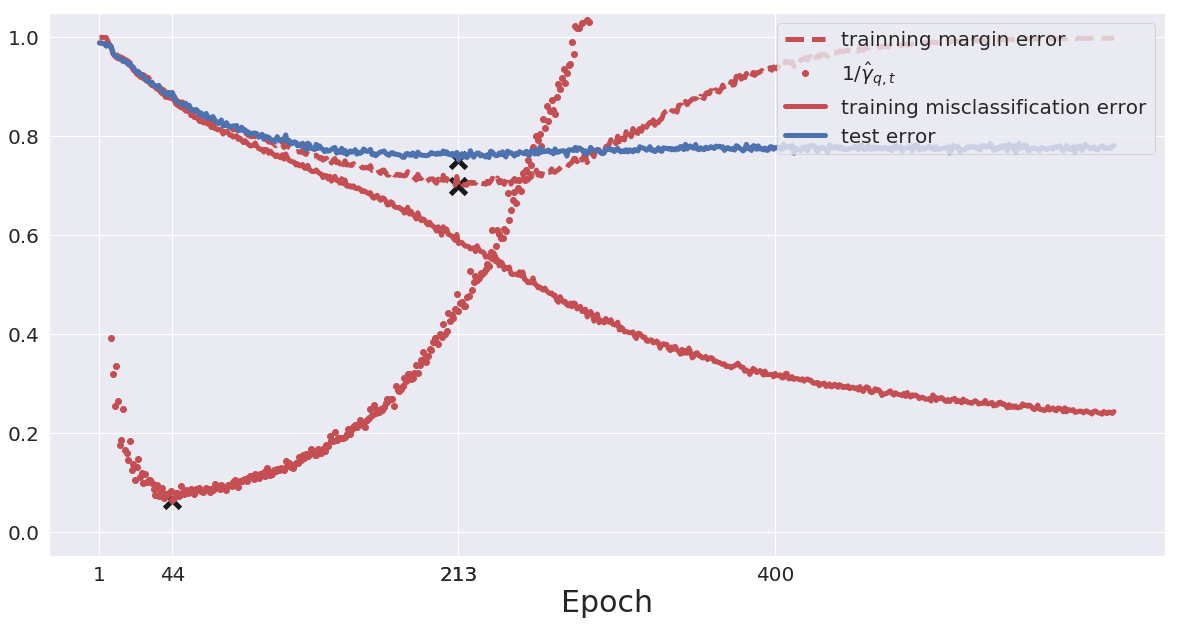

In [39]:
def get_qmargin(margins, q):
    q1 = int(len(margins[0]) * q)
    return [np.partition(margin, q1)[q1] for margin in margins]
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

train_merror=[margin_error(margin, lip *6e3) for (margin, lip) in zip(log_mini['margin_train'], log_mini['Lip'])]
nqMargin_train = np.array(get_qmargin(log_mini['margin_train'],
                                                 0.99)) / np.array(log_mini['Lip'])*5e-5

ax.plot(train_merror
    ,'r--',linewidth=5,
    label='trainning margin error')
ax.plot(1/nqMargin_train,'ro', linewidth=5, label=r'$1/\hat{\gamma}_{q,t}$')

ax.plot(log_mini['train_error'],'r',linewidth=5,label='training misclassification error')
ax.plot(log_mini['test_error'],'b',linewidth=5,label='test error')

#ax.set_xlim(0,100)
ax.set_ylim(-0.05,1.05)
x1=np.argmin(log_mini['test_error'])
ax.scatter(x1,log_mini['test_error'][x1],s=250,c='k',marker='x',linewidth=5)
x2=np.argmin(train_merror)
ax.scatter(x2,train_merror[x2],s=250,c='k',marker='x',linewidth=5)

ax.set_xlabel('Epoch',fontdict={'size': 30})
#fig.savefig('./results_original/margin_error_and_test_error.png')


x3=np.argmin(1/nqMargin_train)
ax.scatter(x3,1/nqMargin_train[x3],s=250,c='k',marker='x',linewidth=5)
ax.set_xticks([0,x1,x2,x3,399])
ax.set_xticklabels([1,x1+1,x2+1,x3+1,400])
ax.legend(loc='upper right',fontsize=20)
#plt.show()
fig.savefig('./alex_results_p0.1/mini_margin_error_and_test_error.png')

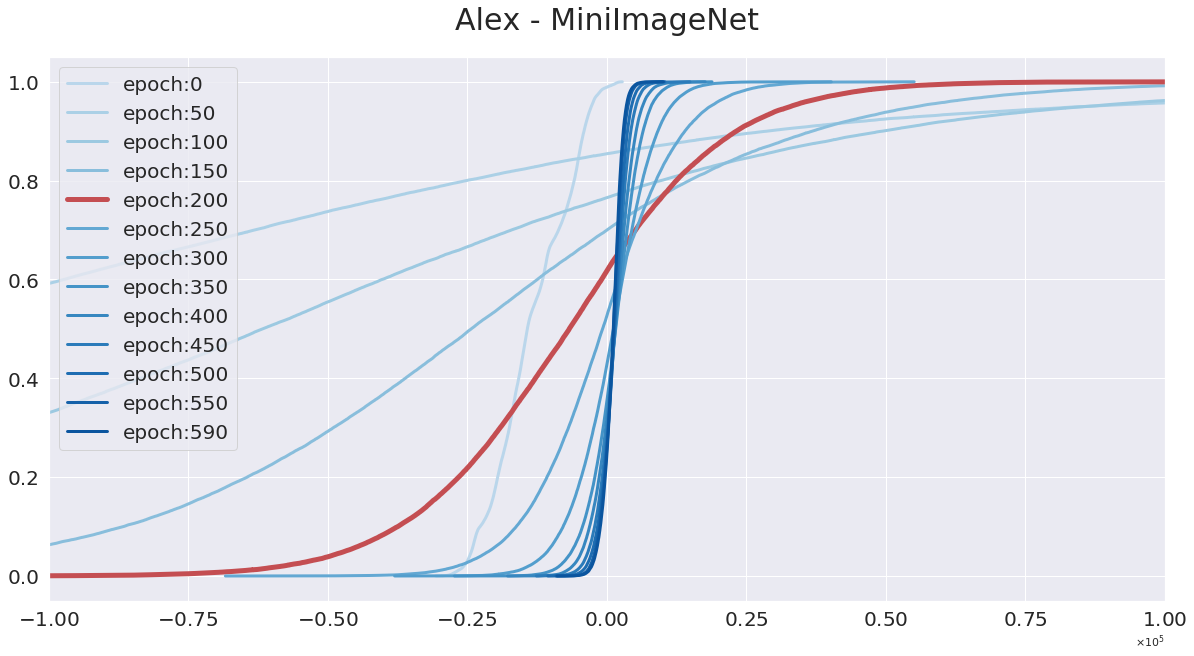

In [40]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
plt.title('Alex - MiniImageNet', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0,50,100,150,200,250,300,350,400,450,500,550,590]):
    if i==200:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_mini['margin_train'][i])/log_mini['Lip'][i], np.arange(50000)/50000,c=c, label=f'epoch:{i}',linewidth=d)
ax.set_xlim([-1e5, 1e5])
ax.legend(fontsize=20,loc='upper left')
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./alex_results_p0.1/'+'mini_nMargin_distribution.png')

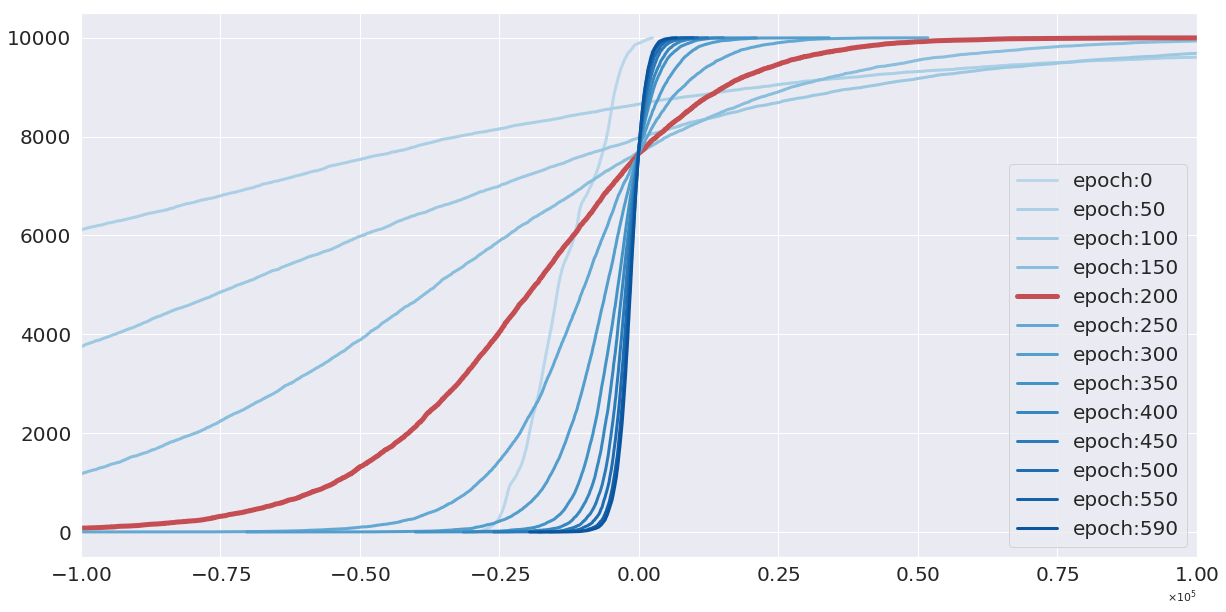

In [15]:
#
fig = plt.figure(1, figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.title('Evolutions of normalized margin distributions', fontsize=30, y=1.04)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for j,i in enumerate([0,50,100,150,200,250,300,350,400,450,500,550,590]):
    if i==200:
        c='r'
        d=5
    else:
        c=sbn.color_palette('Blues',20)[j+5]
        d=3
    ax.plot(np.sort(log_mini['margin_test'][i])/log_mini['Lip'][i], range(10000),c=c, label=f'epoch:{i}',linewidth=d)
ax.set_xlim([-1e5, 1e5])
ax.legend(fontsize=20)
from matplotlib import ticker
formatter=ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.xaxis.set_major_formatter(formatter)
fig.savefig('./alex_results_p0.1/'+'mini_test_nMargin_distribution.png')

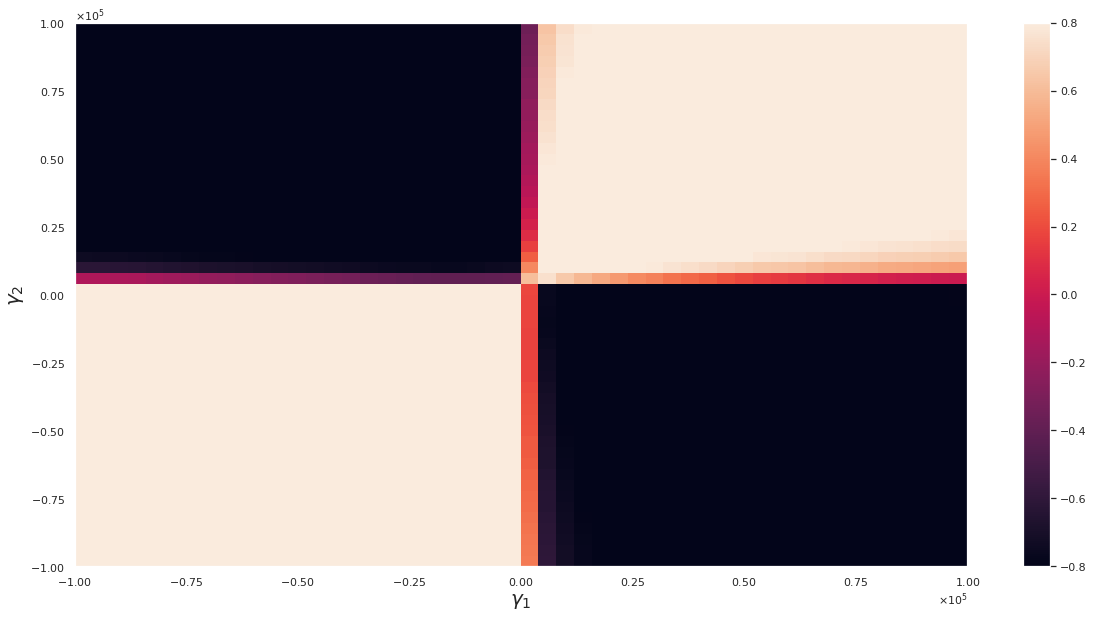

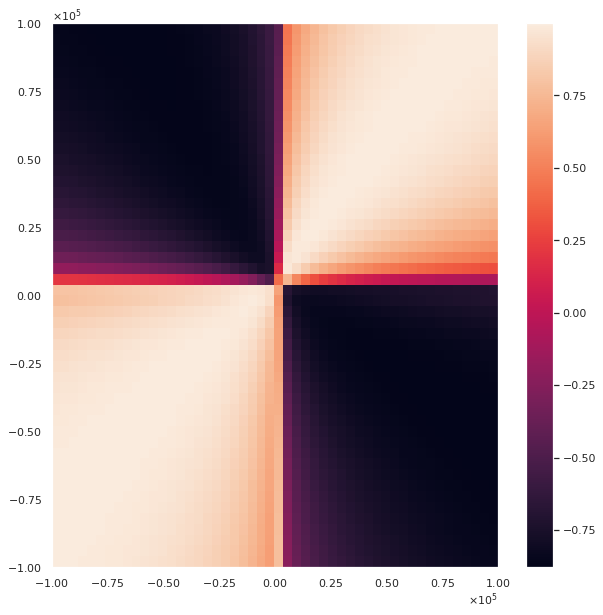

In [41]:
plot_heatmap(log_mini,'./alex_results_p0.1/mini_',np.linspace(-1e5,1e5,51))

In [19]:
import pickle
pickle.dump(log_mini,open('./alex_results_p0.1/log_mini','wb'))